TableNet is a novel approach where both table and table structure are detected. The architecture has two branches where two convolution+ReLU+dropout blocks are shared. This way the common covlutional filters are reinforced by the learning of structure of the table which is useful in the table detection. 

Here we have two datasets: 
1. Marmot
2. Marmot column annotated

Marmot dataset contains both English and Chinese document images. We will limit ourselves with english documents in this case study. 

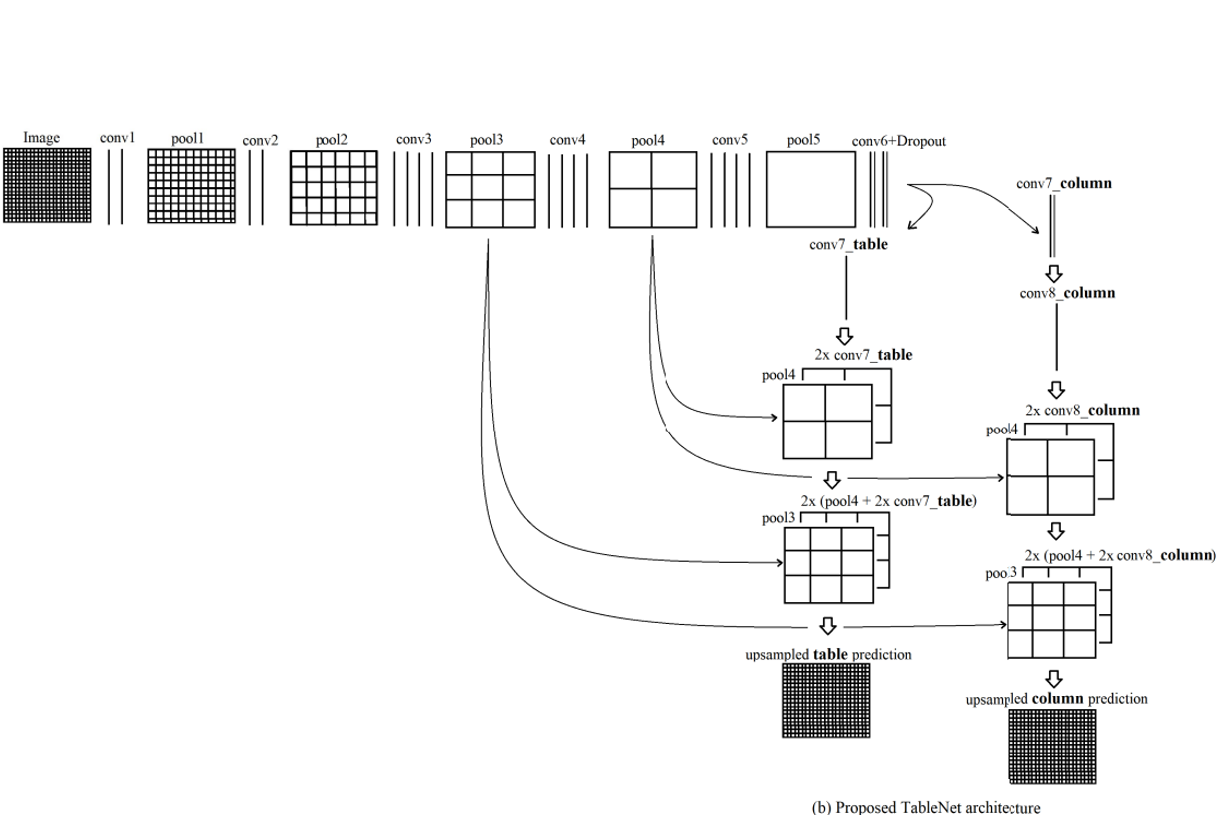

In [1]:
#gneral libraries
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import random as rn

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Image processing libraries
import cv2
from PIL import Image
from PIL import ImageOps


import struct #binary format hanling library
import xml.etree.ElementTree as ET #xml handling library

import warnings
warnings.filterwarnings("ignore")

### Reference: https://www.jeremyjordan.me/semantic-segmentation/

## Augmneting the Image data

In [2]:
import tensorflow as tf
from imgaug import augmenters as iaa

In [31]:
#augumentation techniques
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

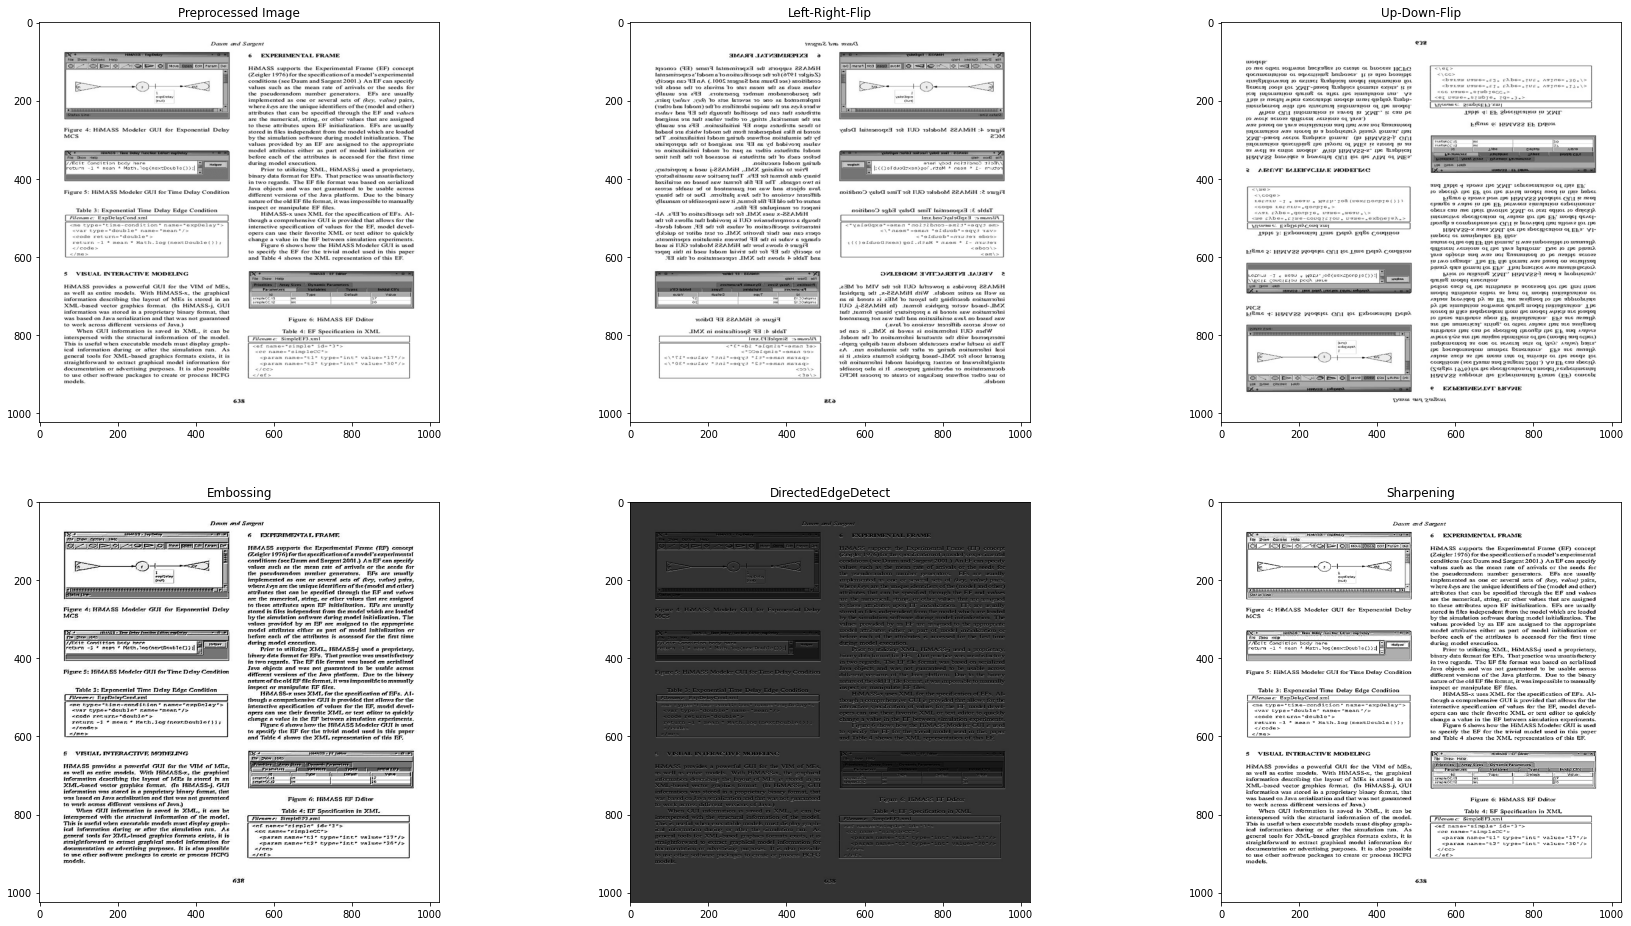

In [32]:
def display_augmentation(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image_aug_1 = image/255.0
    image_aug_2 = aug2.augment_image(image)
    image_aug_3 = aug3.augment_image(image)
    image_aug_4 = aug4.augment_image(image)
    image_aug_5 = aug5.augment_image(image)
    image_aug_6 = aug6.augment_image(image)
    augmentations = [image_aug_1, image_aug_2, image_aug_3, image_aug_4, image_aug_5, image_aug_6]
    titles = ['Preprocessed Image', 'Left-Right-Flip', 'Up-Down-Flip', 'Embossing', 'DirectedEdgeDetect', 'Sharpening']
    
    plt.figure(figsize=(30, 25))
    for i in range(1, 7):
        plt.subplot(3,3, i)
        plt.imshow(np.array(augmentations[i-1]))
        plt.title(titles[i-1])
        
display_augmentation('./marmot_preprocessed/image/10.1.1.1.2010_5.jpeg')

## Creating a Dataloader i.e. Input Data stream for Training

In [33]:
class Dataset:
    '''Reads Input image and preprocess them and returns along with both table and column masks'''
    def __init__(self, df, augmentation=False):
        self.df = df
        self.augmentation = augmentation

        #path of Images
        self.image_path = self.df['image_path'].to_list()
        self.tmask_path = self.df['table_mask_path'].to_list()
        self.cmask_path = self.df['col_mask_path'].to_list()
        
        
    def __getitem__(self, i):
        image = cv2.imread(self.image_path[i], cv2.IMREAD_UNCHANGED)
        image = image/255.0                                               #normalizing the input image range [0,1]
        
        table = cv2.imread(self.tmask_path[i], cv2.IMREAD_UNCHANGED)
        table_mask = np.expand_dims(table/255, axis=-1)                  #normalizing table_mask

        
        column = cv2.imread(self.cmask_path[i], cv2.IMREAD_UNCHANGED)
        column_mask = np.expand_dims(column/255, axis=-1)               #normalizing column_mask 

        
        
        if self.augmentation:
            a = np.random.uniform()                                      #generates an number from uniform distribution
            if a<0.1:                                                    #returns preprocessed image without any augmentation
                return image, table_mask, column_mask
            elif a<0.3:                                                 #returns left-right flipped image
                image = aug2.augment_image(image)
                table_mask = aug2.augment_image(table_mask)
                column_mask = aug2.augment_image(column_mask)
            elif a<0.5:                                                #returns up-down flipped image
                image = aug3.augment_image(image)
                table_mask = aug3.augment_image(table_mask)
                column_mask = aug3.augment_image(column_mask)
            elif a<0.7:                                               #returns embossed image
                image = aug4.augment_image(image)
                table_mask = aug4.augment_image(table_mask)
                column_mask = aug4.augment_image(column_mask)
            elif a<0.9:                                             #returns directedgedetect image
                image = aug5.augment_image(image)
                table_mask = aug5.augment_image(table_mask)
                column_mask = aug5.augment_image(column_mask)
            else:                                                  #returns sharpened image
                image = aug6.augment_image(image)
                table_mask = aug6.augment_image(table_mask)
                column_mask = aug6.augment_image(column_mask)
            
        return image, table_mask, column_mask
        
    def __len__(self):
        return self.df.shape[0]

class Dataloader(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #stacking the images at axis = 0 i.e. shape is (batch_size, height, width, channels)
        return tuple([batch[0],[batch[1],batch[2]]])
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [34]:
from sklearn.model_selection import train_test_split
data = df[['image_path', 'table_mask_path', 'col_mask_path']]
X_train, X_test = train_test_split(data, test_size=0.2, stratify=df['hasTable'], random_state=42)

In [35]:
print("the shape of the train data : ",X_train.shape)
print("the shape of the test data : ",X_test.shape)

the shape of the train data :  (794, 3)
the shape of the test data :  (199, 3)


In [36]:
train_dataset = Dataset(df=X_train, augmentation=True)
test_dataset  = Dataset(df=X_test)

BATCH_SIZE = 2

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
print('the shape of the input image is,', train_dataloader[0][0].shape)
print('the shape of the table mask  is,', train_dataloader[0][1][0].shape)
print('the shape of the column mask is,', train_dataloader[0][1][1].shape)

the shape of the input image is, (2, 1024, 1024, 3)
the shape of the table mask  is, (2, 1024, 1024, 1)
the shape of the column mask is, (2, 1024, 1024, 1)


In [9]:
##imports
from tensorflow.keras.layers import Conv2D, Dense, Activation, Dropout, BatchNormalization, ReLU, Concatenate, Conv2DTranspose
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import Model

## Architecture of the Network

In [11]:
def VGG19(input_shape):
    
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg.trainable = False
    layer_names = ['block3_pool', 'block4_pool',  'block5_pool']
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    
    return model 

In [3]:
def DenseNet121(input_shape):
    
    dense = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    dense.trainable = False
    layer_names = ['conv3_block12_concat', 'conv4_block24_concat',  'relu']
    outputs = [dense.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([dense.input], outputs)
    
    return model 

In [13]:
def RestNet50(input_shape):
    
    rest = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    rest.trainable = False
    layer_names = ['conv3_block4_out', 'conv4_block6_out',  'conv5_block3_out']
    outputs = [rest.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([rest.input], outputs)
    
    return model 

In [14]:
def MobileNet_v2(input_shape):
    
    mobile = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    mobile.trainable = False
    layer_names = ['block_6_expand_relu', 'block_13_expand_relu', 'out_relu']
    outputs = [mobile.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([mobile.input], outputs)
    
    return model 

In [4]:
class TableDecoder(tf.keras.layers.Layer):  #kernels = [(1,1), (2,2)], #strides = [(1,1), (2,2)]

    def __init__(self, kernels, strides):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=kernels[0], filters=64, strides=strides[0], kernel_regularizer=tf.keras.regularizers.l2(0.002)) #First convolutional layer in Table_Decoder

        self.upsample_1_table = Conv2DTranspose(filters=64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_2_table = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_3_table = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_4_table = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_5_table = Conv2DTranspose(filters=1, kernel_size=kernels[1], strides=strides[1], padding='same', activation='sigmoid')

    def call(self, input_, pool3, pool4):
        
        x = self.conv_7(input_)  #input.shape = (None, 32, 32, 256) and output.shape = (None, 32, 32, 256)
        
        x = self.upsample_1_table(x)  #after upsampling output.shape = (None, 64, 64, 256)
        x = Concatenate()([x, pool4]) 
       
        x = self.upsample_2_table(x) #after upsampling output.shape = (None, 128, 128, 256)
        x = Concatenate()([x, pool3]) 
        
        x = self.upsample_3_table(x)
        x = self.upsample_4_table(x)
        x = self.upsample_5_table(x) #after upsampling output.shape = (None, 1024, 1024, 1)
        
        return x

In [5]:
class ColumnDecoder(tf.keras.layers.Layer):    #kernels = [(1,1), (2,2)], #strides = [(1,1), (2,2)]
    
    def __init__(self, kernels, strides):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=kernels[0], filters=64, strides=strides[0], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal') #first conv in column_decoder
        self.drop = Dropout(0.8)
        self.conv_8 = Conv2D(kernel_size=kernels[0], filters=64, strides=strides[0], kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal',) #second conv in column_decoder
        
        self.upsample_1_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_2_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_3_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_4_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_5_column = Conv2DTranspose(filters = 1, kernel_size = kernels[1], strides = strides[1], padding='same', activation='sigmoid')

    def call(self, input_, pool3, pool4):
        
        x = self.conv_7(input_) #input.shape = (None, 32, 32, 256) and output.shape = (None, 32, 32, 256)
        x = self.drop(x)  
        x = self.conv_8(x) #after second convultion output.shape = (None, 32, 32, 256)

        x = self.upsample_1_column(x) #after upsampling output.shape = (None, 64, 64, 256)
        x = Concatenate()([x, pool4]) 
       
        x = self.upsample_2_column(x) #after upsampling output.shape = (None, 128, 128, 256)
        x = Concatenate()([x, pool3]) 
        
        x = self.upsample_3_column(x)
        x = self.upsample_4_column(x)
        x = self.upsample_5_column(x) #after upsampling output.shape = (None, 1024, 1024, 1)

        return x

In [6]:
class TableNet(tf.keras.Model):
    def __init__(self, encoder, branch_kernels, branch_strides, input_shape):
        super(TableNet, self).__init__()
        if encoder == 'VGG19':
            self.feature_extractor = VGG19(input_shape)
        elif encoder == 'DenseNet121':
            self.feature_extractor = DenseNet121(input_shape)
        elif encoder == 'RestNet50':
            self.feature_extractor = RestNet50(input_shape)
        elif encoder == 'MobileNet_v2':
            self.feature_extractor = MobileNet_v2(input_shape)
            
        self.conv_1= Conv2D(filters=64, kernel_size=(1,1), activation='relu', name='common_conv_1', kernel_regularizer=l2(0.04))
        self.drop_1= Dropout(0.8)
        self.conv_2= Conv2D(filters=64, kernel_size=(1,1), activation='relu', name='common_conv_2', kernel_regularizer=l2(0.04))
        self.drop_2= Dropout(0.8)
        
        self.table_branch = TableDecoder(branch_kernels, branch_strides)
        self.column_branch = ColumnDecoder(branch_kernels, branch_strides)
        
    def call(self, x):
        pool3, pool4, pool5 = self.feature_extractor(x)
        
        out = self.conv_1(pool5)
        out = self.drop_1(out)
        out = self.conv_2(out)
        out = self.drop_2(out)
        
        table_output = self.table_branch(out, pool3, pool4)
        column_output = self.column_branch(out, pool3, pool4)
        
        return table_output, column_output

## Fitting on the VGG19 feature_extractor

In [58]:
os.environ['PYTHONHASHSEED'] = '2'

tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(2)
rn.seed(2)

tf.keras.backend.clear_session()

input_shape = (1024, 1024, 3)

kernels = [(1,1), (2,2)]
strides = [(1,1), (2,2)]

model_vgg = TableNet(encoder='VGG19', branch_kernels=kernels, branch_strides = strides, input_shape = input_shape)

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

In [59]:
import datetime

log_dir_1 = "./logs/fit/" + "model_vgg_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print('The path to save tensorboard is', log_dir_1)

#setting path
dir_path_1 = ('./saved_models/model_vgg')
print('the path to save the models is',dir_path_1)

The path to save tensorboard is ./logs/fit/model_vgg_20220525-141424
the path to save the models is ./saved_models/model_vgg


In [60]:
#Initializing the callbacks
checkpoint = ModelCheckpoint(filepath=dir_path_1, monitor= "val_output_1_loss", verbose=1, save_best_only=True, mode='min')

reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.01, verbose=1, patience=2, mode='min')

tensorboard_callback = TensorBoard(log_dir=log_dir_1, histogram_freq=1, write_graph=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

callback_list = [checkpoint, reduce_lr_plateau, tensorboard_callback, early_stop]

2022-05-25 14:14:34.865770: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-25 14:14:34.865838: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-25 14:14:35.089934: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-25 14:14:35.090126: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [4]:
#https://stackoverflow.com/questions/64474463/custom-f1-score-metric-in-tensorflow
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)
        
losses = {"output_1": 'binary_crossentropy', "output_2": 'binary_crossentropy'}

In [62]:
TRAIN_STEPS = X_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = X_test.shape[0] // BATCH_SIZE
EPOCHS=20
#fitting generator
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=losses, metrics=[F1_Score()])
history_vgg = model_vgg.fit(train_dataloader, epochs=EPOCHS, steps_per_epoch=TRAIN_STEPS, validation_data=test_dataloader, validation_steps=VALIDATION_STEPS,
                    batch_size=BATCH_SIZE, callbacks=callback_list)

Epoch 1/20
  1/397 [..............................] - ETA: 24:23 - loss: 11.6389 - output_1_loss: 1.5659 - output_2_loss: 1.7900 - output_1_f1_score: 0.0000e+00 - output_2_f1_score: 0.0000e+00

2022-05-25 14:14:43.873572: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-25 14:14:43.873628: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/397 [..............................] - ETA: 2:55 - loss: 11.3580 - output_1_loss: 1.4293 - output_2_loss: 1.6546 - output_1_f1_score: 0.0103 - output_2_f1_score: 0.0097         

2022-05-25 14:14:44.479772: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-25 14:14:44.480909: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-25 14:14:44.624441: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 551 callback api events and 545 activity events. 
2022-05-25 14:14:44.639197: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-25 14:14:44.656603: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/fit/model_vgg_20220525-141424/train/plugins/profile/2022_05_25_14_14_44

2022-05-25 14:14:44.666705: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/fit/model_vgg_20220525-141424/train/plugins/profile/2022_05_25_14_14_44/64aab6f21cec.trace.json.gz


  3/397 [..............................] - ETA: 3:30 - loss: 11.5661 - output_1_loss: 1.5804 - output_2_loss: 1.7206 - output_1_f1_score: 0.1666 - output_2_f1_score: 0.1671

2022-05-25 14:14:44.696967: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/fit/model_vgg_20220525-141424/train/plugins/profile/2022_05_25_14_14_44

2022-05-25 14:14:44.702006: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/fit/model_vgg_20220525-141424/train/plugins/profile/2022_05_25_14_14_44/64aab6f21cec.memory_profile.json.gz
2022-05-25 14:14:44.703547: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/fit/model_vgg_20220525-141424/train/plugins/profile/2022_05_25_14_14_44
Dumped tool data for xplane.pb to ./logs/fit/model_vgg_20220525-141424/train/plugins/profile/2022_05_25_14_14_44/64aab6f21cec.xplane.pb
Dumped tool data for overview_page.pb to ./logs/fit/model_vgg_20220525-141424/train/plugins/profile/2022_05_25_14_14_44/64aab6f21cec.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/fit/model_vgg_20220525-141424/tr

397/397 [==============================] - 93s 226ms/step - loss: 6.2502 - output_1_loss: 0.3579 - output_2_loss: 0.3109 - output_1_f1_score: 0.2431 - output_2_f1_score: 0.1494 - val_loss: 4.0127 - val_output_1_loss: 0.2367 - val_output_2_loss: 0.1984 - val_output_1_f1_score: 0.5223 - val_output_2_f1_score: 0.4153

Epoch 00001: val_output_1_loss improved from inf to 0.23675, saving model to ./saved_models/model_vgg
Epoch 2/20
397/397 [==============================] - 89s 225ms/step - loss: 2.8675 - output_1_loss: 0.2084 - output_2_loss: 0.1761 - output_1_f1_score: 0.4667 - output_2_f1_score: 0.3428 - val_loss: 1.9932 - val_output_1_loss: 0.1842 - val_output_2_loss: 0.1490 - val_output_1_f1_score: 0.5425 - val_output_2_f1_score: 0.4061

Epoch 00002: val_output_1_loss improved from 0.23675 to 0.18425, saving model to ./saved_models/model_vgg
Epoch 3/20
397/397 [==============================] - 89s 223ms/step - loss: 1.5331 - output_1_loss: 0.1850 - output_2_loss: 0.1524 - output_1_f1_s

In [63]:
model_vgg.summary()

Model: "table_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           [(None, 128, 128, 256), ( 20024384  
_________________________________________________________________
common_conv_1 (Conv2D)       multiple                  32832     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
common_conv_2 (Conv2D)       multiple                  4160      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
table_decoder (TableDecoder) multiple                  266817    
_________________________________________________________________
column_decoder (ColumnDecode multiple                  27

## Utilites

In [64]:
def visualize_training(history):
    '''utitlity function to plot the training history of the network'''
    
    epochs = [i for i in range(1, len(history.history['loss'])+1)]
    terms = ['lr', 'output_1_loss', 'output_2_loss', 'output_1_f1_score', 'output_2_f1_score', 'loss']
    val_terms = ['lr', 'val_output_1_loss', 'val_output_2_loss', 'val_output_1_f1_score', 'val_output_2_f1_score', 'val_loss']
    titles = ['learning_rate', 'table_loss', 'column_loss', 'table_f1_score', 'column_f1_score', 'aggregated_loss']

    plt.figure(figsize=(20,20))
    for i in range(6):
        plt.subplot(3,3,i+1)
        plt.plot(epochs, history.history[terms[i]],label=terms[i])
        plt.plot(epochs, history.history[val_terms[i]],label=val_terms[i])
        plt.xticks(epochs)
        plt.legend(loc='lower left')
        plt.grid()
        plt.title('epochs vs '+titles[i])
    plt.show()

References
1. https://www.educba.com/opencv-approxpolydp/ 
2. https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18

In [7]:
def get_pred_masks(model, input_image_path, preprocessing=False):
    '''predicting the table and column masks for given image using the given model'''
    
    if preprocessing:
        image_original = Image.open(input_image_path)
        image = image_original.convert('L').convert('RGB')                   #converting the input image into greyscale and again into RGB to remove the different colors of the image.
        image = ImageOps.equalize(image, mask=None)                         #histogram equilization
        input_image_processed = np.array(image.resize(new_image_shape))   #resizing Image to new shape
    else:
        input_image_processed = cv2.imread(input_image_path, cv2.IMREAD_UNCHANGED)
        
    input_image = np.expand_dims(input_image_processed/255.0, axis=0) #expanding the dimensions to add batch_size such that it is compatible
    
    table_mask_pred, column_mask_pred = model(input_image) #predicting the masks using trained model 
    
    
    table_mask = np.squeeze(tf.cast((table_mask_pred>0.5), dtype=tf.int32).numpy(), axis=0).astype(np.uint8)
    column_mask = np.squeeze(tf.cast((column_mask_pred>0.5), dtype=tf.int32).numpy(), axis=0).astype(np.uint8)
    
    return input_image_processed, table_mask, column_mask

In [9]:
def visualize_predictions(model, input_image_path, preprocessing=False):
    '''utility function used to plot the predicted and original masks for comparision of performance'''
    
    input_image_processed, table_mask, column_mask = get_pred_masks(model, input_image_path, preprocessing=preprocessing)
    
    first_slash = input_image_path.find('/')
    second_slash = input_image_path.find('/', first_slash+1)
    
    original_table_mask_path = './marmot_preprocessed/table_mask/'+input_image_path[second_slash+1:]
    original_table_mask = cv2.imread(original_table_mask_path, cv2.IMREAD_UNCHANGED)
    
    original_column_mask_path = './marmot_preprocessed/col_mask/'+input_image_path[second_slash+1:]
    original_column_mask = cv2.imread(original_column_mask_path, cv2.IMREAD_UNCHANGED)
    
    
    if not preprocessing:
        f, ax = plt.subplots(2,3, figsize = (30,20))
    
        ax[0][0].imshow(input_image_processed)
        ax[0][0].set_title('Original Image')
        ax[0][1].imshow(table_mask)
        ax[0][1].set_title('Predicted Table mask')
        ax[0][2].imshow(column_mask)
        ax[0][2].set_title('Predicted Column mask')
        ax[1][1].imshow(original_table_mask)
        ax[1][1].set_title('Original Table mask')
        ax[1][2].imshow(original_column_mask)
        ax[1][2].set_title('Original Column mask')

        plt.show()
    else:
        f, ax = plt.subplots(1,3, figsize = (30,20))
    
        ax[0].imshow(input_image_processed)
        ax[0].set_title('Original Image')
        ax[1].imshow(table_mask)
        ax[1].set_title('Predicted Table mask')
        ax[2].imshow(column_mask)
        ax[2].set_title('Predicted Column mask')
        plt.show

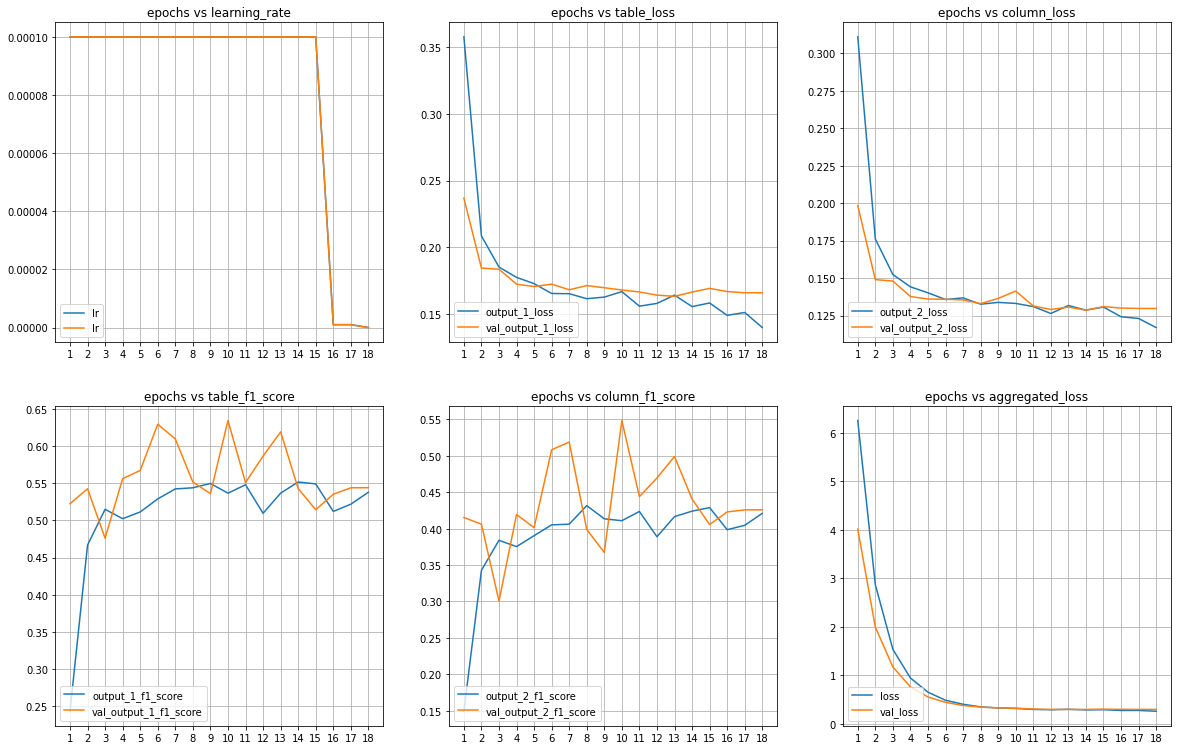

In [67]:
visualize_training(history_vgg)

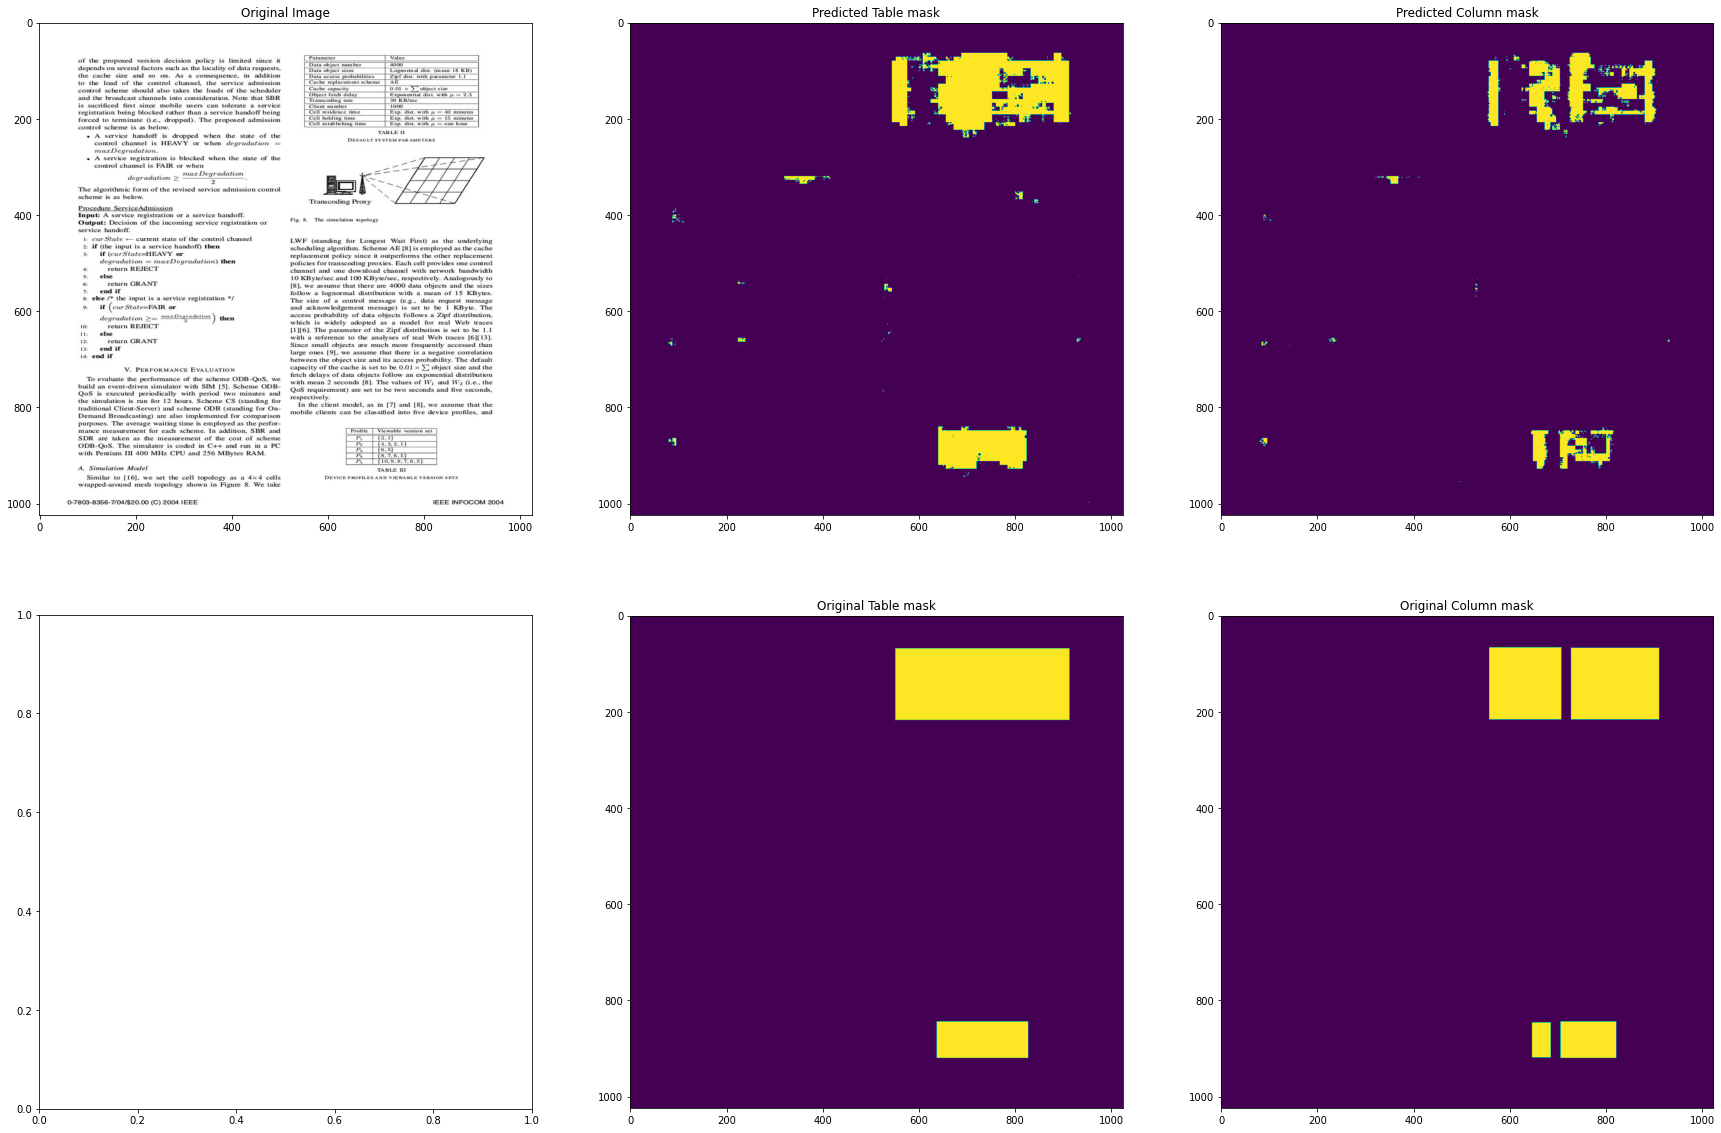

In [81]:
visualize_predictions(model_vgg, 'marmot_preprocessed/image/10.1.1.1.2018_8.jpeg')

## Fitting on the DenseNet121 feature_extractor

In [10]:
os.environ['PYTHONHASHSEED'] = '2'

tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(2)
rn.seed(2)

tf.keras.backend.clear_session()

input_shape = (1024, 1024, 3)

kernels = [(1,1), (2,2)]
strides = [(1,1), (2,2)]

model_dense = TableNet(encoder='DenseNet121', branch_kernels=kernels, branch_strides = strides, input_shape = input_shape)

In [83]:
log_dir_2 = "./logs/fit/" + "model_dense_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print('The path to save tensorboard is', log_dir_2)

#setting path
dir_path_2 = ('./saved_models/model_dense')
print('the path to save the models is',dir_path_2)

The path to save tensorboard is ./logs/fit/model_dense_20220525-145546
the path to save the models is ./saved_models/model_dense


In [84]:
checkpoint_2 = ModelCheckpoint(filepath=dir_path_2, monitor= "val_output_1_loss", verbose=1, save_best_only=True, mode='min')

tensorboard_callback_2 = TensorBoard(log_dir=log_dir_2, histogram_freq=1, write_graph=True)

callback_list_2 = [checkpoint_2, reduce_lr_plateau, early_stop, tensorboard_callback_2]

2022-05-25 14:55:47.962917: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-25 14:55:47.963059: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-25 14:55:48.236780: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-25 14:55:48.236978: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [85]:
#fitting generator
model_dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=losses, metrics=[F1_Score()])
history_dense = model_dense.fit(train_dataloader, epochs=EPOCHS, steps_per_epoch=TRAIN_STEPS, validation_data=test_dataloader, validation_steps=VALIDATION_STEPS,
                    batch_size=BATCH_SIZE, callbacks=callback_list_2)

Epoch 1/20
  1/397 [..............................] - ETA: 52:56 - loss: 9.8846 - output_1_loss: 0.6940 - output_2_loss: 0.6953 - output_1_f1_score: 0.0000e+00 - output_2_f1_score: 0.0000e+00

2022-05-25 14:55:59.115104: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-25 14:55:59.115156: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/397 [..............................] - ETA: 3:44 - loss: 9.8701 - output_1_loss: 0.6927 - output_2_loss: 0.6942 - output_1_f1_score: 0.0107 - output_2_f1_score: 0.0093         

2022-05-25 14:55:59.873723: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-25 14:55:59.875908: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-25 14:56:00.026369: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1101 callback api events and 1095 activity events. 
2022-05-25 14:56:00.055800: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-25 14:56:00.089160: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/fit/model_dense_20220525-145546/train/plugins/profile/2022_05_25_14_56_00

2022-05-25 14:56:00.107112: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/fit/model_dense_20220525-145546/train/plugins/profile/2022_05_25_14_56_00/64aab6f21cec.trace.json.gz
2022-05-25 14:56:00.159498: I tensorflow/core/profil

397/397 [==============================] - 88s 203ms/step - loss: 5.8692 - output_1_loss: 0.3355 - output_2_loss: 0.2758 - output_1_f1_score: 0.0215 - output_2_f1_score: 0.0272 - val_loss: 3.5583 - val_output_1_loss: 0.2477 - val_output_2_loss: 0.1926 - val_output_1_f1_score: 0.0000e+00 - val_output_2_f1_score: 0.0000e+00

Epoch 00001: val_output_1_loss improved from inf to 0.24769, saving model to ./saved_models/model_dense
Epoch 2/20
397/397 [==============================] - 80s 200ms/step - loss: 2.5031 - output_1_loss: 0.1890 - output_2_loss: 0.1551 - output_1_f1_score: 0.2475 - output_2_f1_score: 0.0666 - val_loss: 1.7658 - val_output_1_loss: 0.1429 - val_output_2_loss: 0.1388 - val_output_1_f1_score: 0.6055 - val_output_2_f1_score: 0.2595

Epoch 00002: val_output_1_loss improved from 0.24769 to 0.14295, saving model to ./saved_models/model_dense
Epoch 3/20
397/397 [==============================] - 78s 197ms/step - loss: 1.3762 - output_1_loss: 0.1369 - output_2_loss: 0.1183 - o

In [86]:
model_dense.summary()

Model: "table_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           [(None, 128, 128, 512), ( 7037504   
_________________________________________________________________
common_conv_1 (Conv2D)       multiple                  65600     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
common_conv_2 (Conv2D)       multiple                  4160      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
table_decoder (TableDecoder) multiple                  463425    
_________________________________________________________________
column_decoder (ColumnDecode multiple                  46

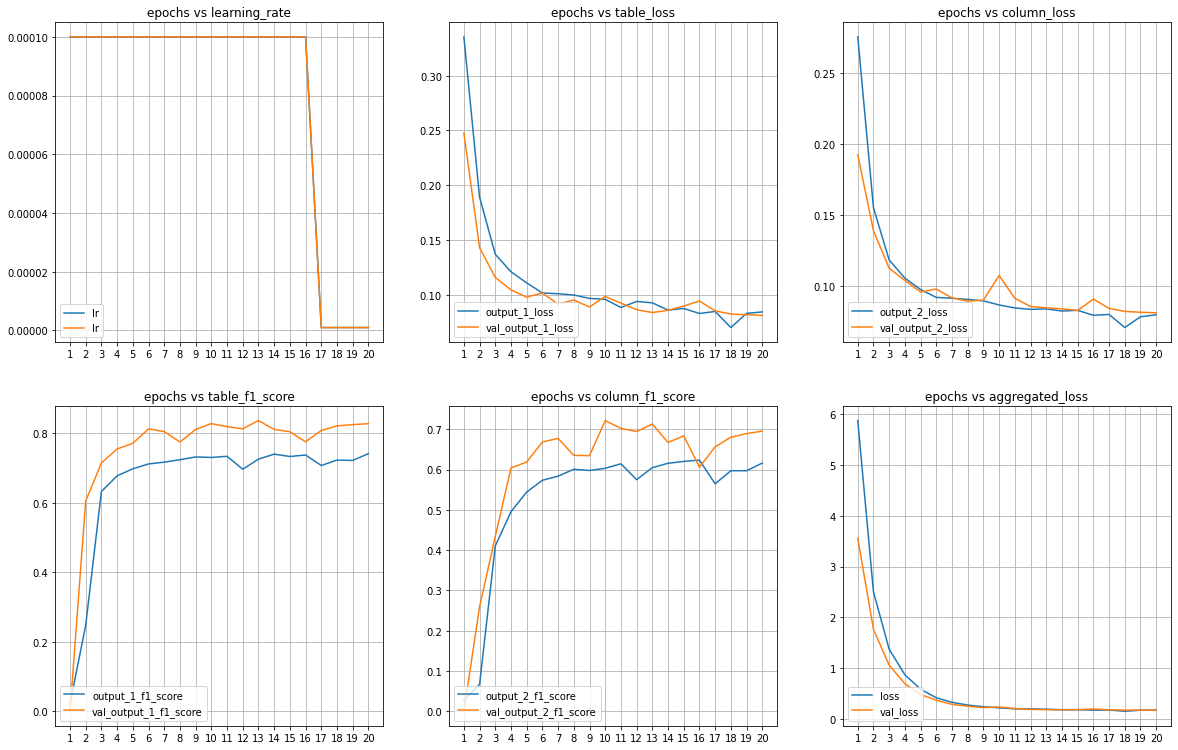

In [87]:
visualize_training(history_dense)

In [88]:
visualize_predictions(model_dense, 'marmot_preprocessed/image/10.1.1.1.2018_8.jpeg')

## Fitting on the RestNet50 feature_extractor

In [89]:
os.environ['PYTHONHASHSEED'] = '2'

tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(2)
rn.seed(2)

tf.keras.backend.clear_session()

model_rest = TableNet(encoder='RestNet50', branch_kernels=kernels, branch_strides = strides, input_shape = input_shape)

94781440/94765736 [==============================] - 1s 0us/step


In [90]:
log_dir_3 = "./logs/fit/" + "model_rest_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print('The path to save tensorboard is', log_dir_3)

#setting path
dir_path_3 = ('./saved_models/model_rest')
print('the path to save the models is',dir_path_3)

The path to save tensorboard is ./logs/fit/model_rest_20220525-153620
the path to save the models is ./saved_models/model_rest


In [91]:
checkpoint_3 = ModelCheckpoint(filepath=dir_path_3, monitor= "val_output_1_loss", verbose=1, save_best_only=True, mode='min')

tensorboard_callback_3 = TensorBoard(log_dir=log_dir_3, histogram_freq=1, write_graph=True)

callback_list_3 = [checkpoint_3, reduce_lr_plateau, early_stop, tensorboard_callback_3]

2022-05-25 15:36:20.892808: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-25 15:36:20.892849: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-25 15:36:21.101087: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-25 15:36:21.101269: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [92]:
#fitting generator
model_rest.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=losses, metrics=[F1_Score()])
history_rest = model_rest.fit(train_dataloader, epochs=EPOCHS, steps_per_epoch=TRAIN_STEPS, validation_data=test_dataloader, validation_steps=VALIDATION_STEPS,
                    batch_size=BATCH_SIZE, callbacks=callback_list_3)

Epoch 1/20
  1/397 [..............................] - ETA: 32:40 - loss: 10.0718 - output_1_loss: 0.7064 - output_2_loss: 0.6886 - output_1_f1_score: 0.0000e+00 - output_2_f1_score: 0.0000e+00

2022-05-25 15:36:26.762561: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-25 15:36:26.762611: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/397 [..............................] - ETA: 3:08 - loss: 10.0437 - output_1_loss: 0.7004 - output_2_loss: 0.6827 - output_1_f1_score: 0.0108 - output_2_f1_score: 0.0093         

2022-05-25 15:36:27.574723: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-25 15:36:27.576725: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-25 15:36:27.723232: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 798 callback api events and 792 activity events. 
2022-05-25 15:36:27.743914: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-25 15:36:27.768989: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/fit/model_rest_20220525-153620/train/plugins/profile/2022_05_25_15_36_27

2022-05-25 15:36:27.783444: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/fit/model_rest_20220525-153620/train/plugins/profile/2022_05_25_15_36_27/64aab6f21cec.trace.json.gz
2022-05-25 15:36:27.828099: I tensorflow/core/profiler/r

397/397 [==============================] - 85s 201ms/step - loss: 5.3600 - output_1_loss: 0.3058 - output_2_loss: 0.2413 - output_1_f1_score: 0.0191 - output_2_f1_score: 0.0200 - val_loss: 3.1247 - val_output_1_loss: 0.2813 - val_output_2_loss: 0.2096 - val_output_1_f1_score: 0.0000e+00 - val_output_2_f1_score: 0.0000e+00

Epoch 00001: val_output_1_loss improved from inf to 0.28127, saving model to ./saved_models/model_rest
Epoch 2/20
397/397 [==============================] - 79s 198ms/step - loss: 2.3125 - output_1_loss: 0.2492 - output_2_loss: 0.1922 - output_1_f1_score: 0.0176 - output_2_f1_score: 7.0146e-04 - val_loss: 1.8059 - val_output_1_loss: 0.2629 - val_output_2_loss: 0.1996 - val_output_1_f1_score: 0.0000e+00 - val_output_2_f1_score: 0.0000e+00

Epoch 00002: val_output_1_loss improved from 0.28127 to 0.26293, saving model to ./saved_models/model_rest
Epoch 3/20
397/397 [==============================] - 78s 196ms/step - loss: 1.4276 - output_1_loss: 0.2202 - output_2_loss: 

In [93]:
model_rest.summary()

Model: "table_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           [(None, 128, 128, 512), ( 23587712  
_________________________________________________________________
common_conv_1 (Conv2D)       multiple                  131136    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
common_conv_2 (Conv2D)       multiple                  4160      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
table_decoder (TableDecoder) multiple                  463425    
_________________________________________________________________
column_decoder (ColumnDecode multiple                  46

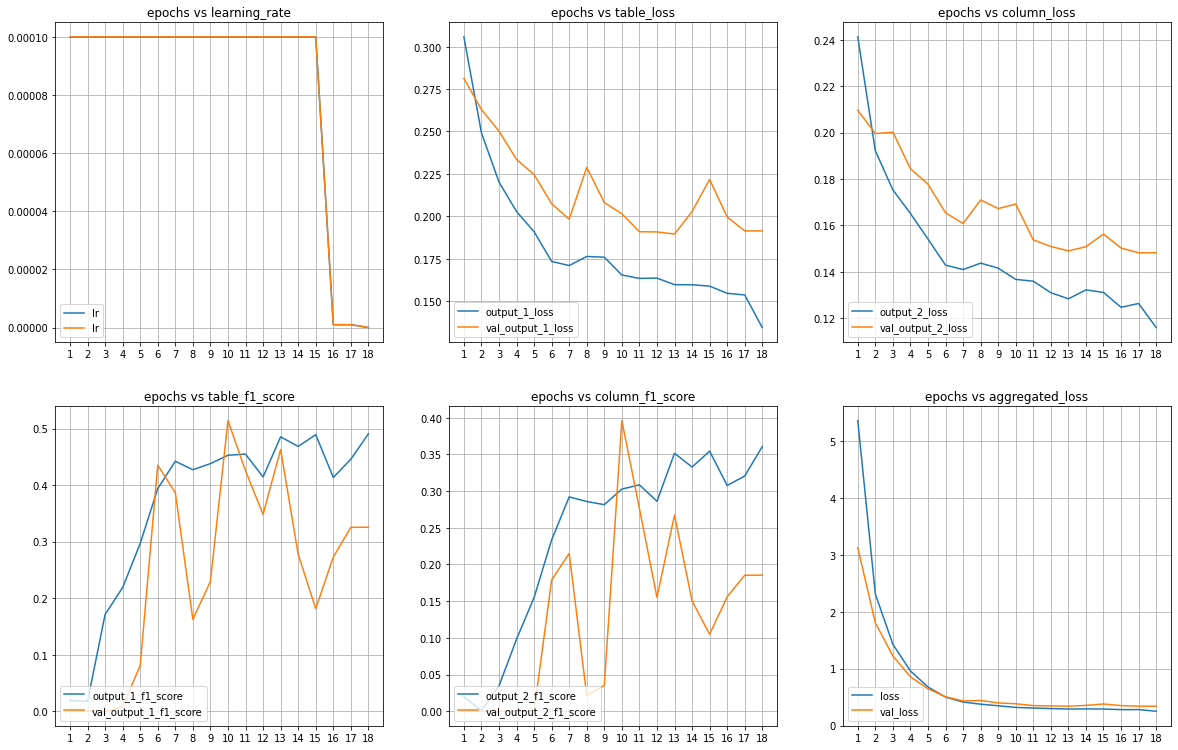

In [94]:
visualize_training(history_rest)

In [95]:
visualize_predictions(model_rest, 'marmot_preprocessed/image/10.1.1.1.2018_8.jpeg')

## Fitting on the MobileNet_v2 feature_extractor

In [108]:
os.environ['PYTHONHASHSEED'] = '2'

tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(2)
rn.seed(2)

tf.keras.backend.clear_session()

model_mobile = TableNet(encoder='MobileNet_v2', branch_kernels=kernels, branch_strides = strides, input_shape = input_shape)

In [109]:
log_dir_4 = "./logs/fit/" + "model_mobile_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print('The path to save tensorboard is', log_dir_4)

#setting path
dir_path_4 = ('./saved_models/model_mobile')
print('the path to save the models is',dir_path_4)

The path to save tensorboard is ./logs/fit/model_mobile_20220525-165449
the path to save the models is ./saved_models/model_mobile


In [110]:
checkpoint_4 = ModelCheckpoint(filepath=dir_path_4, monitor= "val_output_1_loss", verbose=1, save_best_only=True, mode='min')

tensorboard_callback_4 = TensorBoard(log_dir=log_dir_4, histogram_freq=1, write_graph=True)

callback_list_4 = [checkpoint_4, reduce_lr_plateau, early_stop, tensorboard_callback_4]

2022-05-25 16:54:50.664344: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-25 16:54:50.664407: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-25 16:54:50.859520: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-25 16:54:50.859709: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [111]:
#fitting generator
model_mobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=losses, metrics=[F1_Score()])
history_mobile = model_mobile.fit(train_dataloader, epochs=EPOCHS, steps_per_epoch=TRAIN_STEPS, validation_data=test_dataloader, validation_steps=VALIDATION_STEPS,
                    batch_size=BATCH_SIZE, callbacks=callback_list_4)

Epoch 1/20
  1/397 [..............................] - ETA: 30:46 - loss: 9.9743 - output_1_loss: 0.6978 - output_2_loss: 0.6802 - output_1_f1_score: 0.0000e+00 - output_2_f1_score: 0.0000e+00

2022-05-25 16:54:56.950632: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-25 16:54:56.950687: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/397 [..............................] - ETA: 2:32 - loss: 9.9560 - output_1_loss: 0.6954 - output_2_loss: 0.6776 - output_1_f1_score: 0.0112 - output_2_f1_score: 0.0096         

2022-05-25 16:54:57.432885: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-25 16:54:57.434600: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-25 16:54:57.578197: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 714 callback api events and 708 activity events. 
2022-05-25 16:54:57.598572: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-25 16:54:57.621080: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/fit/model_mobile_20220525-165449/train/plugins/profile/2022_05_25_16_54_57



  3/397 [..............................] - ETA: 3:09 - loss: 9.9470 - output_1_loss: 0.6957 - output_2_loss: 0.6814 - output_1_f1_score: 0.1896 - output_2_f1_score: 0.1639

2022-05-25 16:54:57.634165: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/fit/model_mobile_20220525-165449/train/plugins/profile/2022_05_25_16_54_57/64aab6f21cec.trace.json.gz
2022-05-25 16:54:57.680726: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/fit/model_mobile_20220525-165449/train/plugins/profile/2022_05_25_16_54_57

2022-05-25 16:54:57.687102: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/fit/model_mobile_20220525-165449/train/plugins/profile/2022_05_25_16_54_57/64aab6f21cec.memory_profile.json.gz
2022-05-25 16:54:57.689549: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/fit/model_mobile_20220525-165449/train/plugins/profile/2022_05_25_16_54_57
Dumped tool data for xplane.pb to ./logs/fit/model_mobile_20220525-165449/train/plugins/profile/2022_05_25_16_54_57/

397/397 [==============================] - 79s 187ms/step - loss: 5.7434 - output_1_loss: 0.3254 - output_2_loss: 0.2642 - output_1_f1_score: 0.0303 - output_2_f1_score: 0.0258 - val_loss: 3.4015 - val_output_1_loss: 0.2255 - val_output_2_loss: 0.1924 - val_output_1_f1_score: 0.0543 - val_output_2_f1_score: 0.0045

Epoch 00001: val_output_1_loss improved from inf to 0.22546, saving model to ./saved_models/model_mobile
Epoch 2/20
397/397 [==============================] - 74s 187ms/step - loss: 2.4248 - output_1_loss: 0.1856 - output_2_loss: 0.1540 - output_1_f1_score: 0.3007 - output_2_f1_score: 0.0904 - val_loss: 1.7676 - val_output_1_loss: 0.1604 - val_output_2_loss: 0.1483 - val_output_1_f1_score: 0.5853 - val_output_2_f1_score: 0.3149

Epoch 00002: val_output_1_loss improved from 0.22546 to 0.16037, saving model to ./saved_models/model_mobile
Epoch 3/20
397/397 [==============================] - 73s 183ms/step - loss: 1.3968 - output_1_loss: 0.1524 - output_2_loss: 0.1298 - output_

In [112]:
model_mobile.summary()

Model: "table_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           [(None, 128, 128, 192), ( 2257984   
_________________________________________________________________
common_conv_1 (Conv2D)       multiple                  81984     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
common_conv_2 (Conv2D)       multiple                  4160      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
table_decoder (TableDecoder) multiple                  266817    
_________________________________________________________________
column_decoder (ColumnDecode multiple                  27

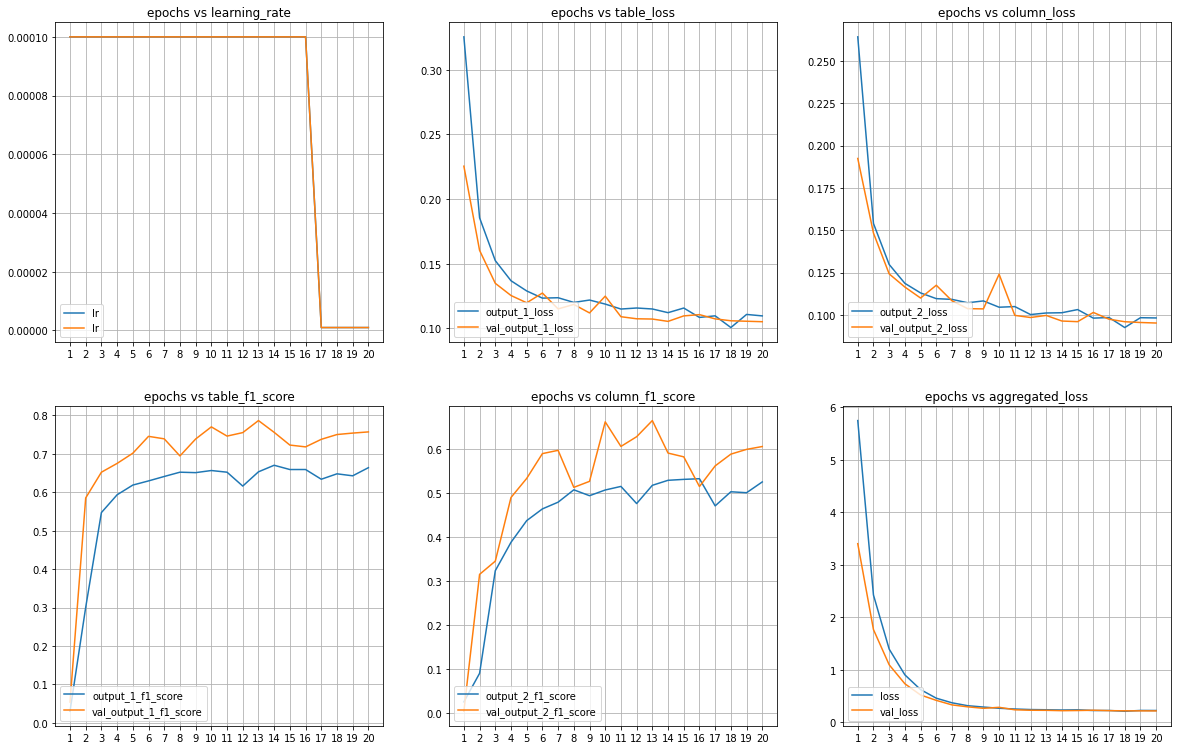

In [113]:
visualize_training(history_mobile)

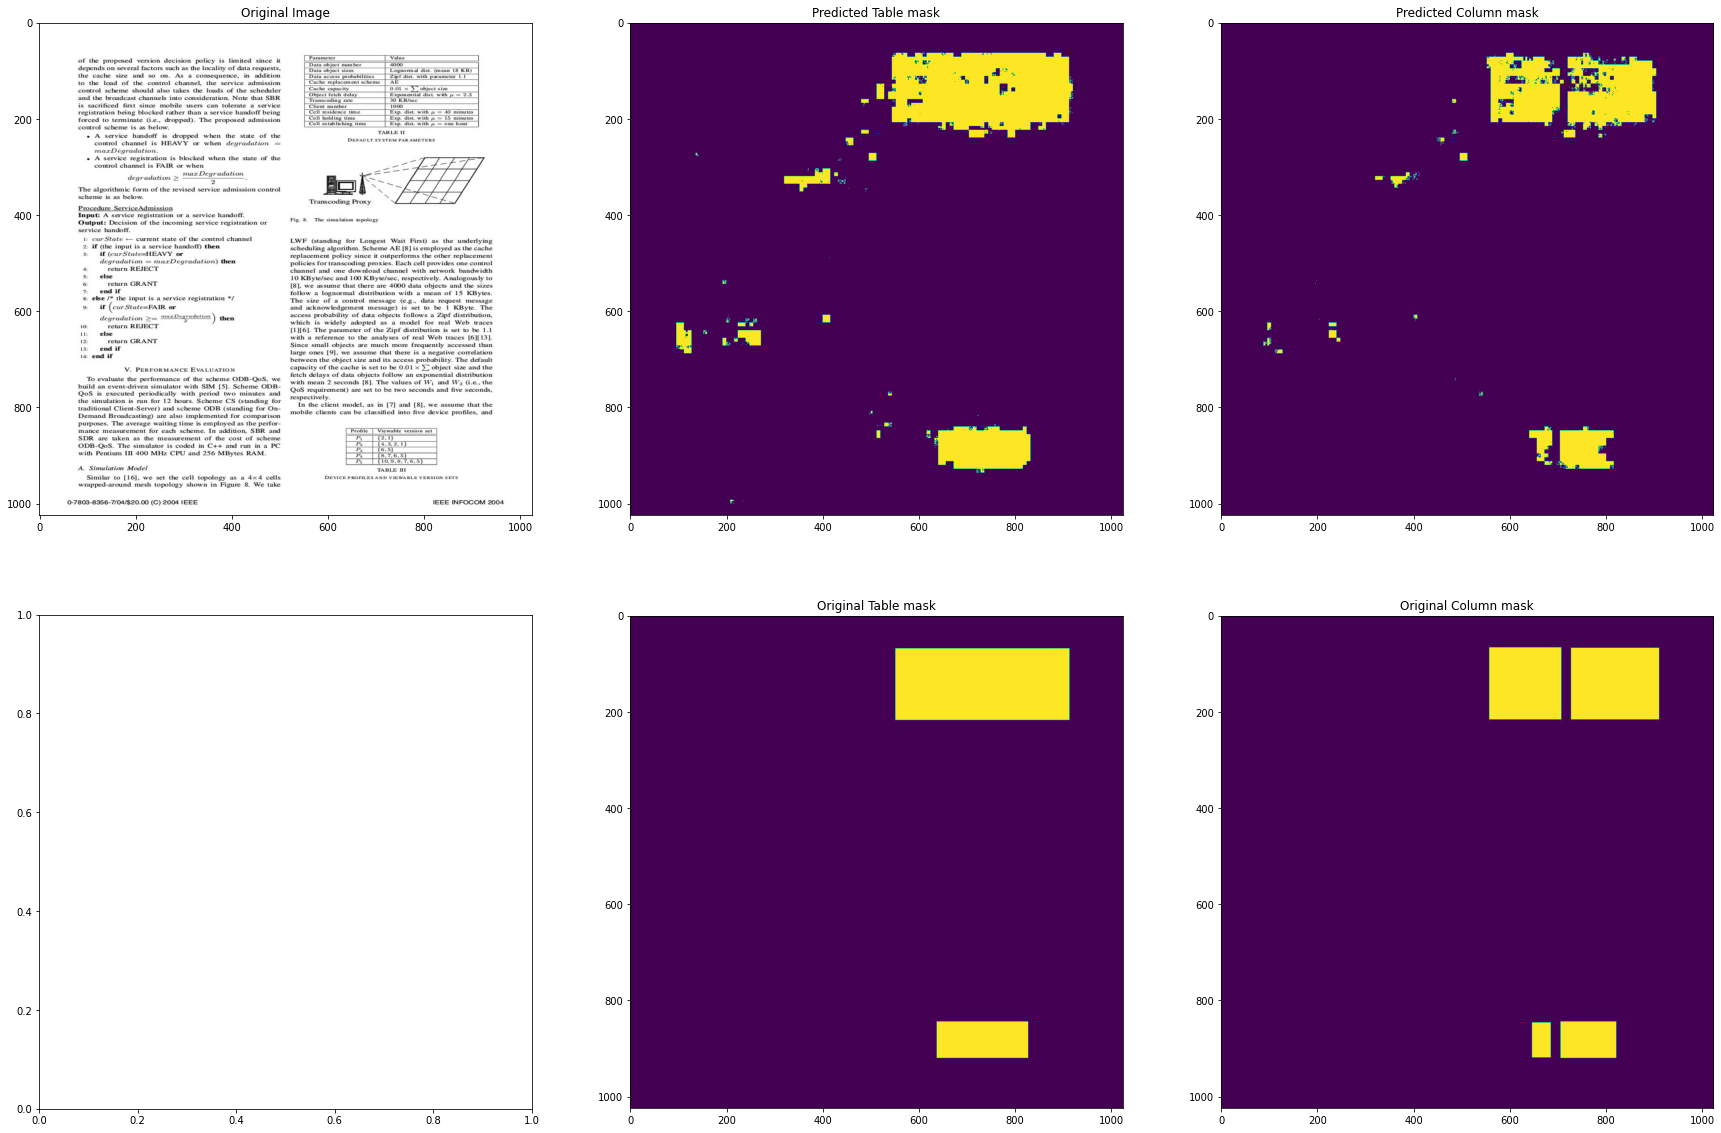

In [114]:
visualize_predictions(model_mobile, 'marmot_preprocessed/image/10.1.1.1.2018_8.jpeg')

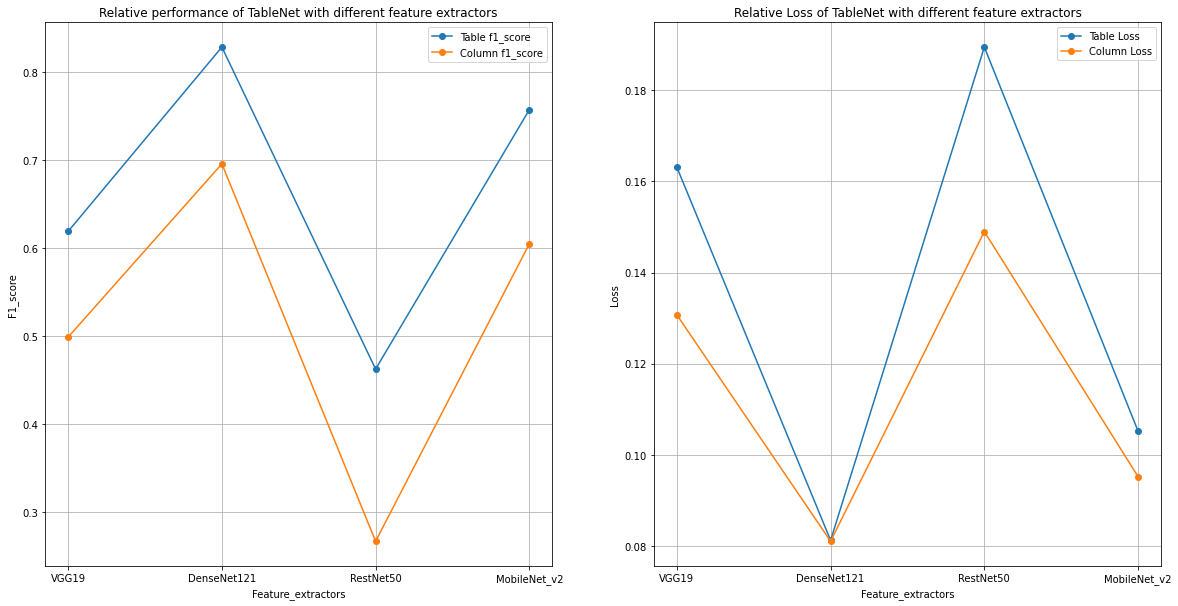

In [7]:
#comparing models
models = ['VGG19', 'DenseNet121', 'RestNet50', 'MobileNet_v2']
f1_scores = {'table_f1_score':[0.6190, 0.8281, 0.4627, 0.7570], 'column_f1_score':[0.4990, 0.6956, 0.2673, 0.6048]}
model_loss = {'table_loss':[0.1631, 0.0812, 0.1895, 0.1052], 'column_loss':[0.1307, 0.0810, 0.1490,  0.0952]}


fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(models, f1_scores['table_f1_score'], marker='o' )
ax[0].plot(models, f1_scores['column_f1_score'], marker='o')
ax[0].legend(['Table f1_score', 'Column f1_score'])
ax[0].set_ylabel('F1_score')
ax[0].set_xlabel('Feature_extractors')
ax[0].grid()
ax[0].set_title('Relative performance of TableNet with different feature extractors')


ax[1].plot(models, model_loss['table_loss'], marker='o' )
ax[1].plot(models, model_loss['column_loss'], marker='o')
ax[1].legend(['Table Loss', 'Column Loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Feature_extractors')
ax[1].grid()
ax[1].set_title('Relative Loss of TableNet with different feature extractors')

plt.show()

In [9]:
import prettytable
from prettytable import PrettyTable
TB = PrettyTable()

TB.title = "Performance of TableNet with various Feature Extractor"
TB.field_names = ['Feature Extractor', 'Table_F1_score', 'Table_loss', 'Column_F1_score', 'Column_loss']
TB.add_row(['VGG19', 0.6190, 0.1631, 0.4990, 0.1307])
TB.add_row(['DenseNet121',0.8281, 0.0812, 0.6956, 0.0810])
TB.add_row(['RestNet50', 0.4627, 0.1895, 0.2673, 0.1490 ])
TB.add_row(['MobileNet_v2',0.7570, 0.1052, 0.6048, 0.0952])


print(TB)

+---------------------------------------------------------------------------------+
|              Performance of TableNet with various Feature Extractor             |
+-------------------+----------------+------------+-----------------+-------------+
| Feature Extractor | Table_F1_score | Table_loss | Column_F1_score | Column_loss |
+-------------------+----------------+------------+-----------------+-------------+
|       VGG19       |     0.619      |   0.1631   |      0.499      |    0.1307   |
|    DenseNet121    |     0.8281     |   0.0812   |      0.6956     |    0.081    |
|     RestNet50     |     0.4627     |   0.1895   |      0.2673     |    0.149    |
|    MobileNet_v2   |     0.757      |   0.1052   |      0.6048     |    0.0952   |
+-------------------+----------------+------------+-----------------+-------------+


# Visualize predictions on sample data

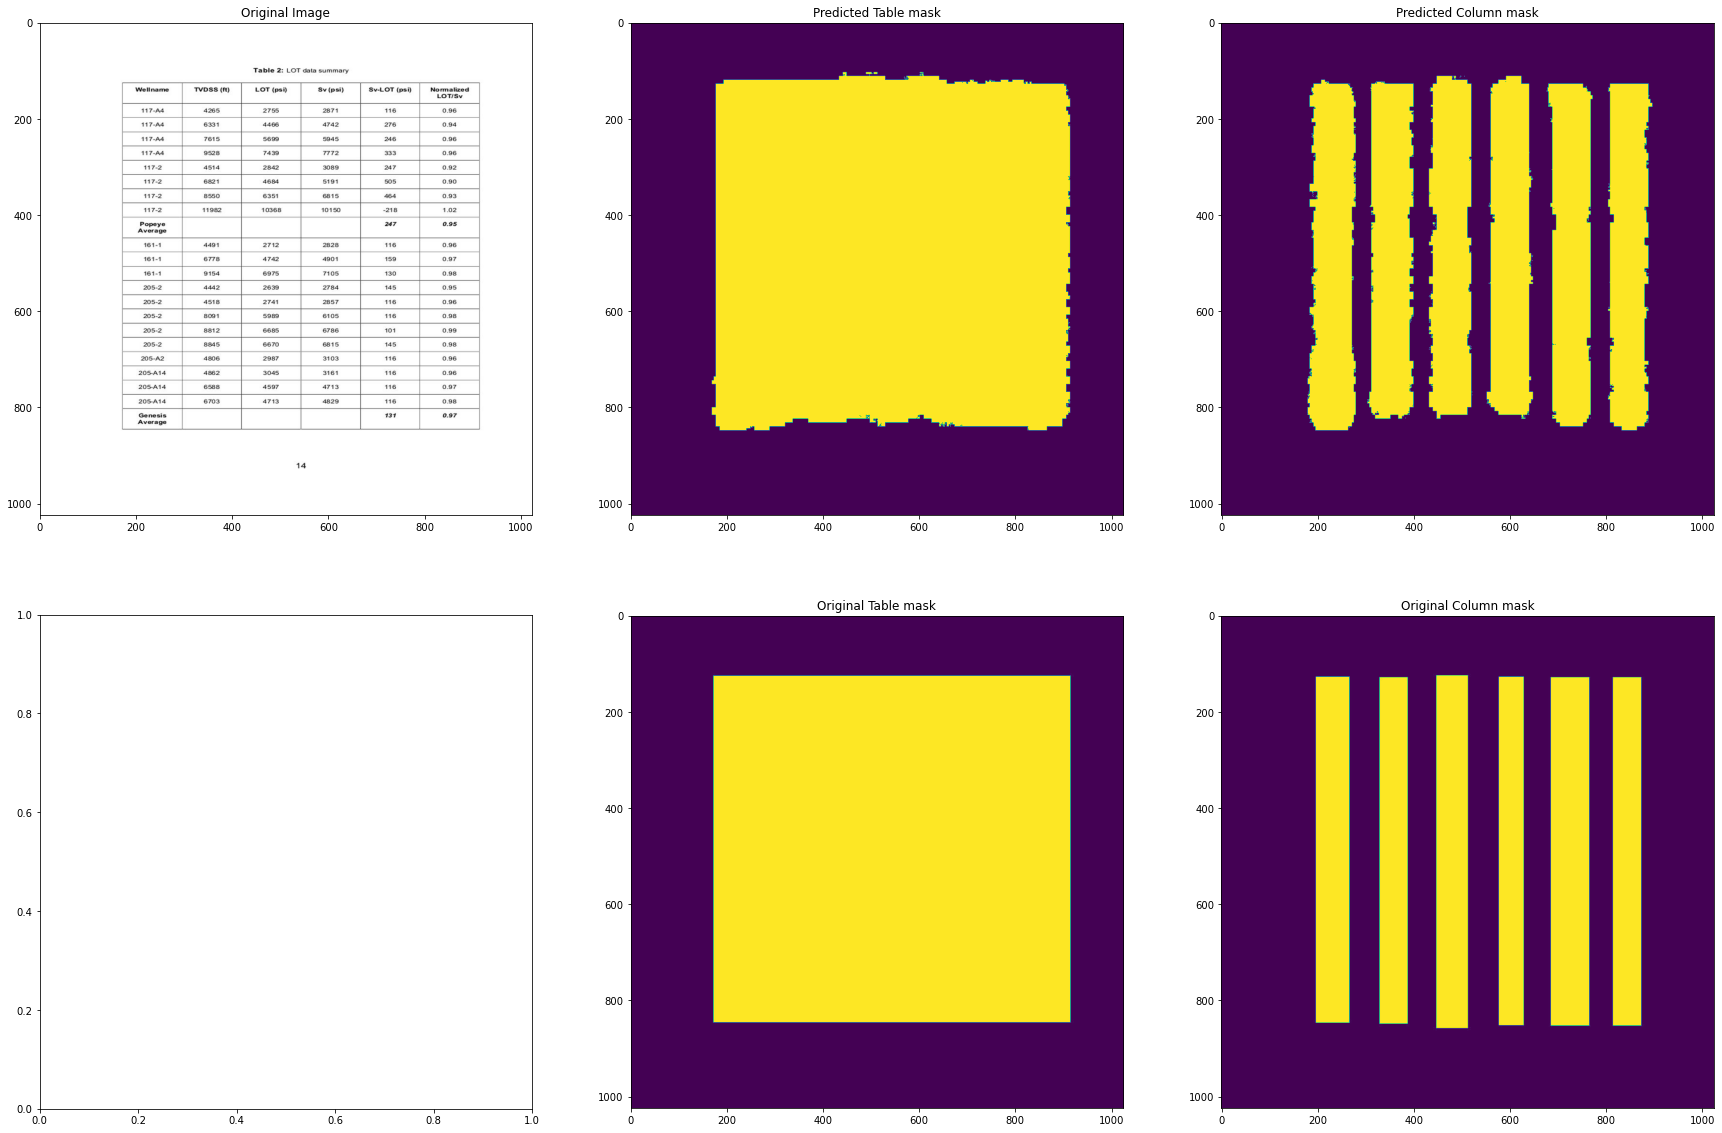

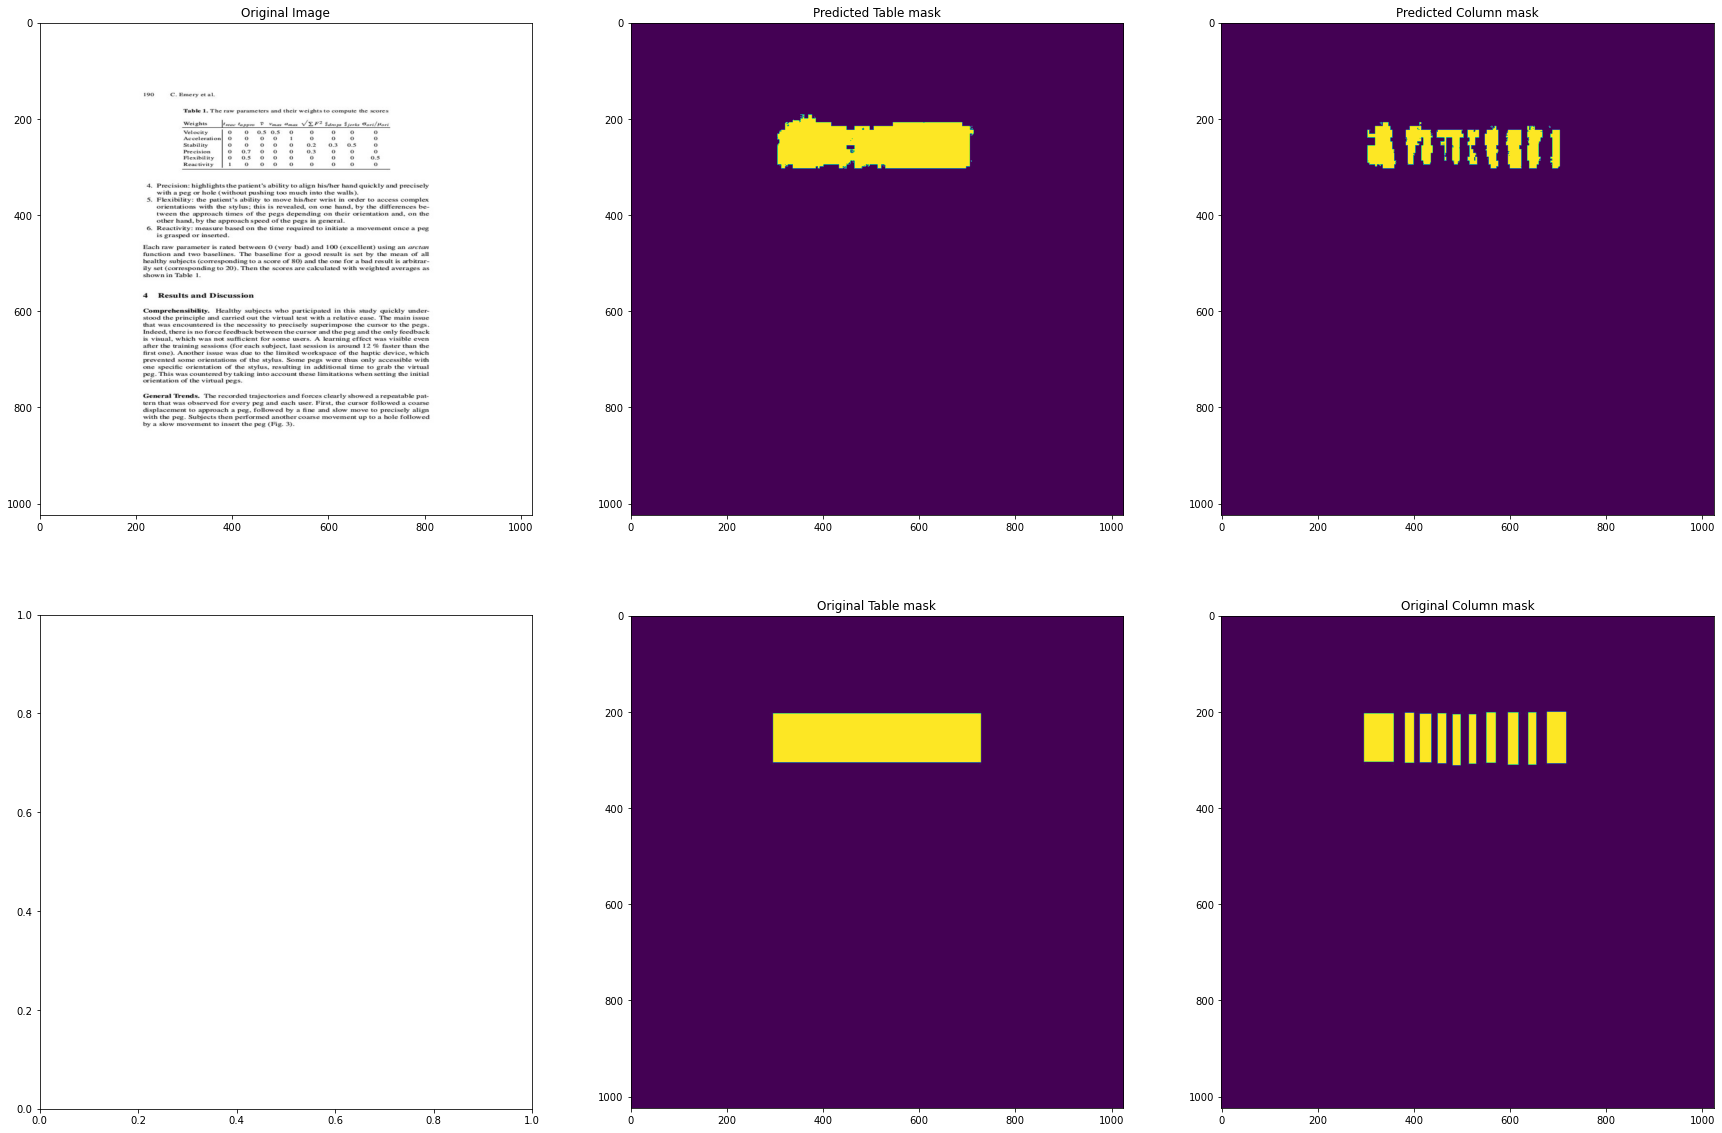

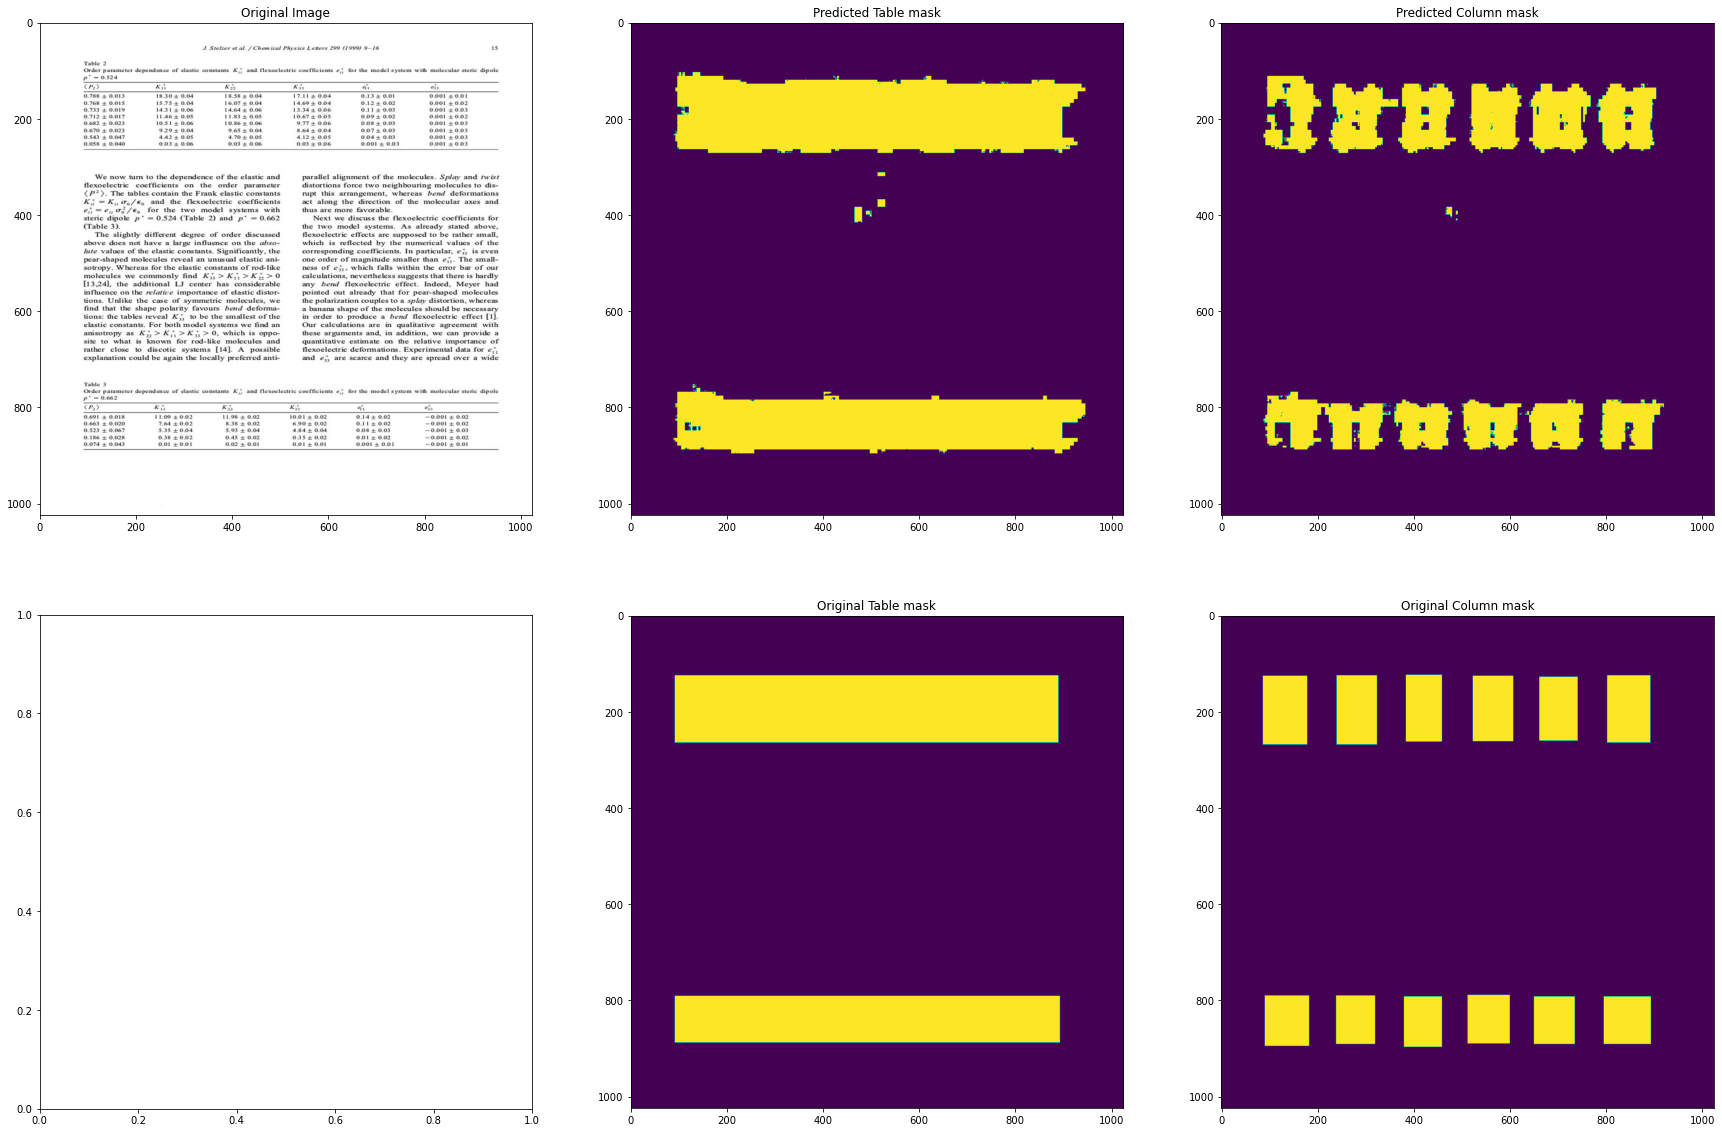

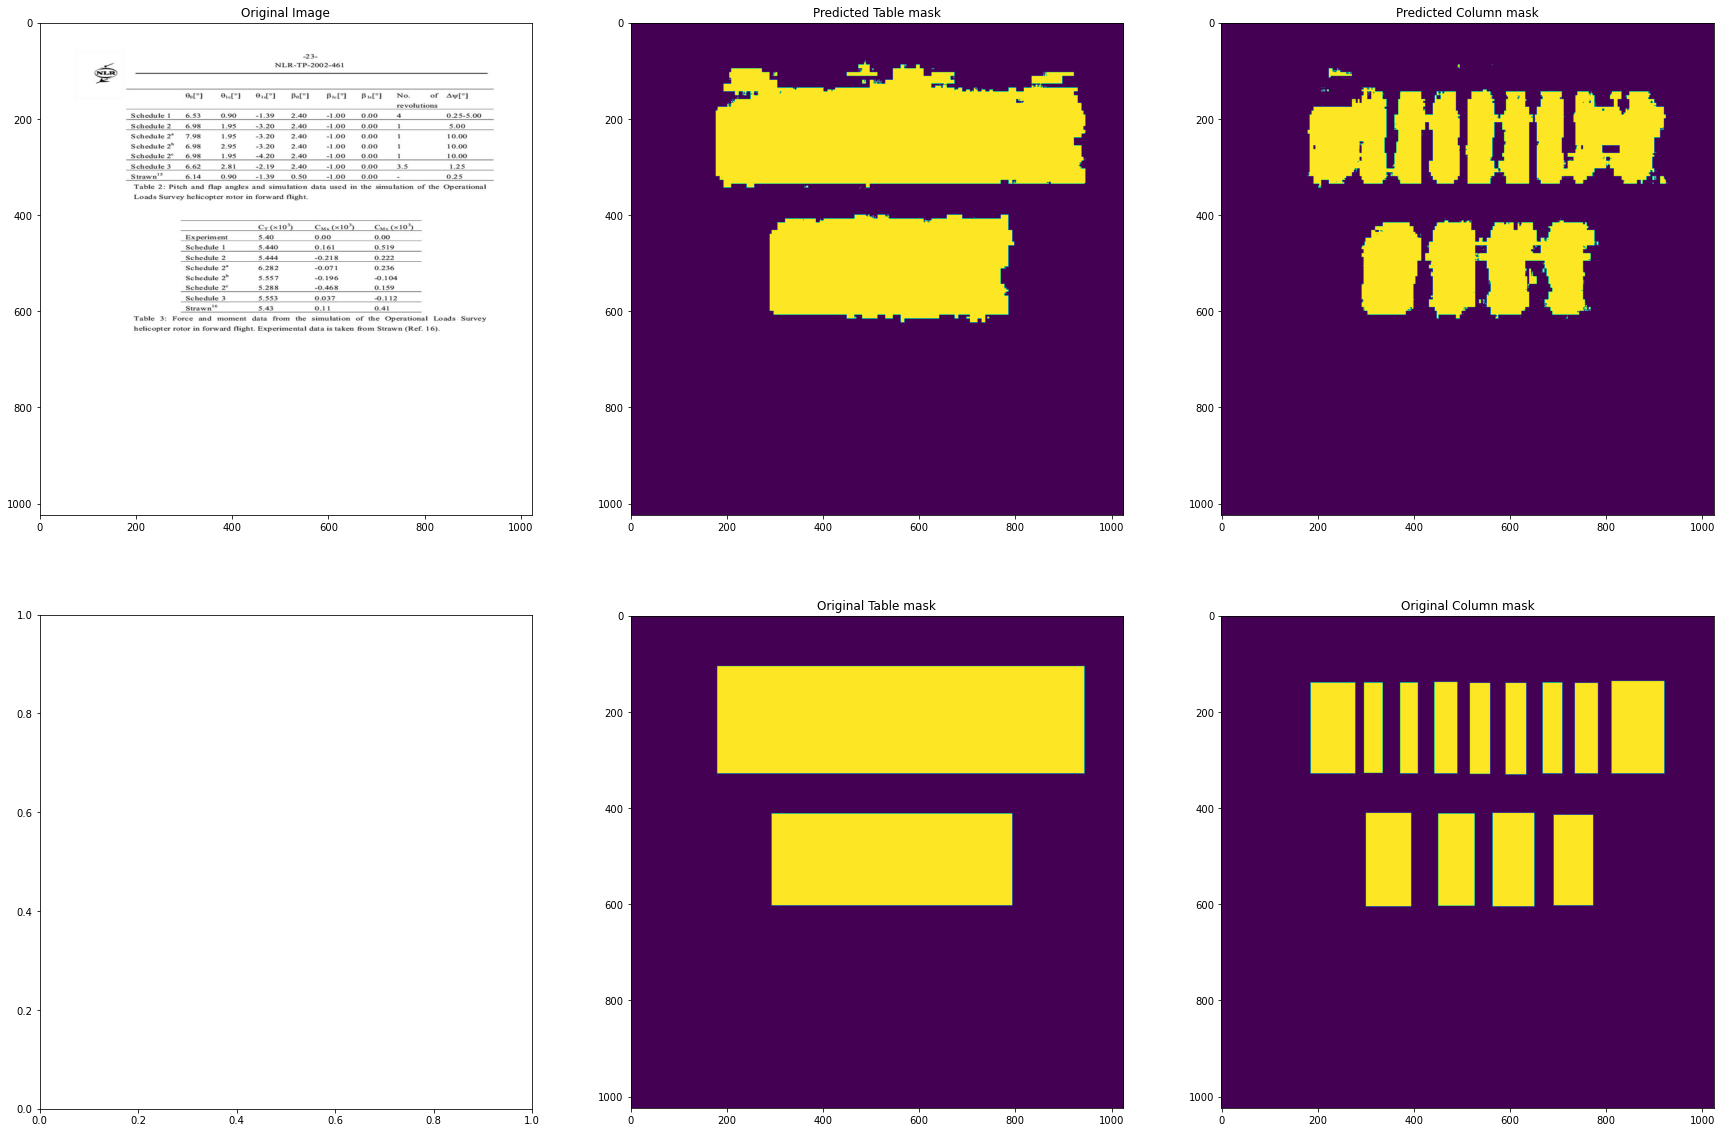

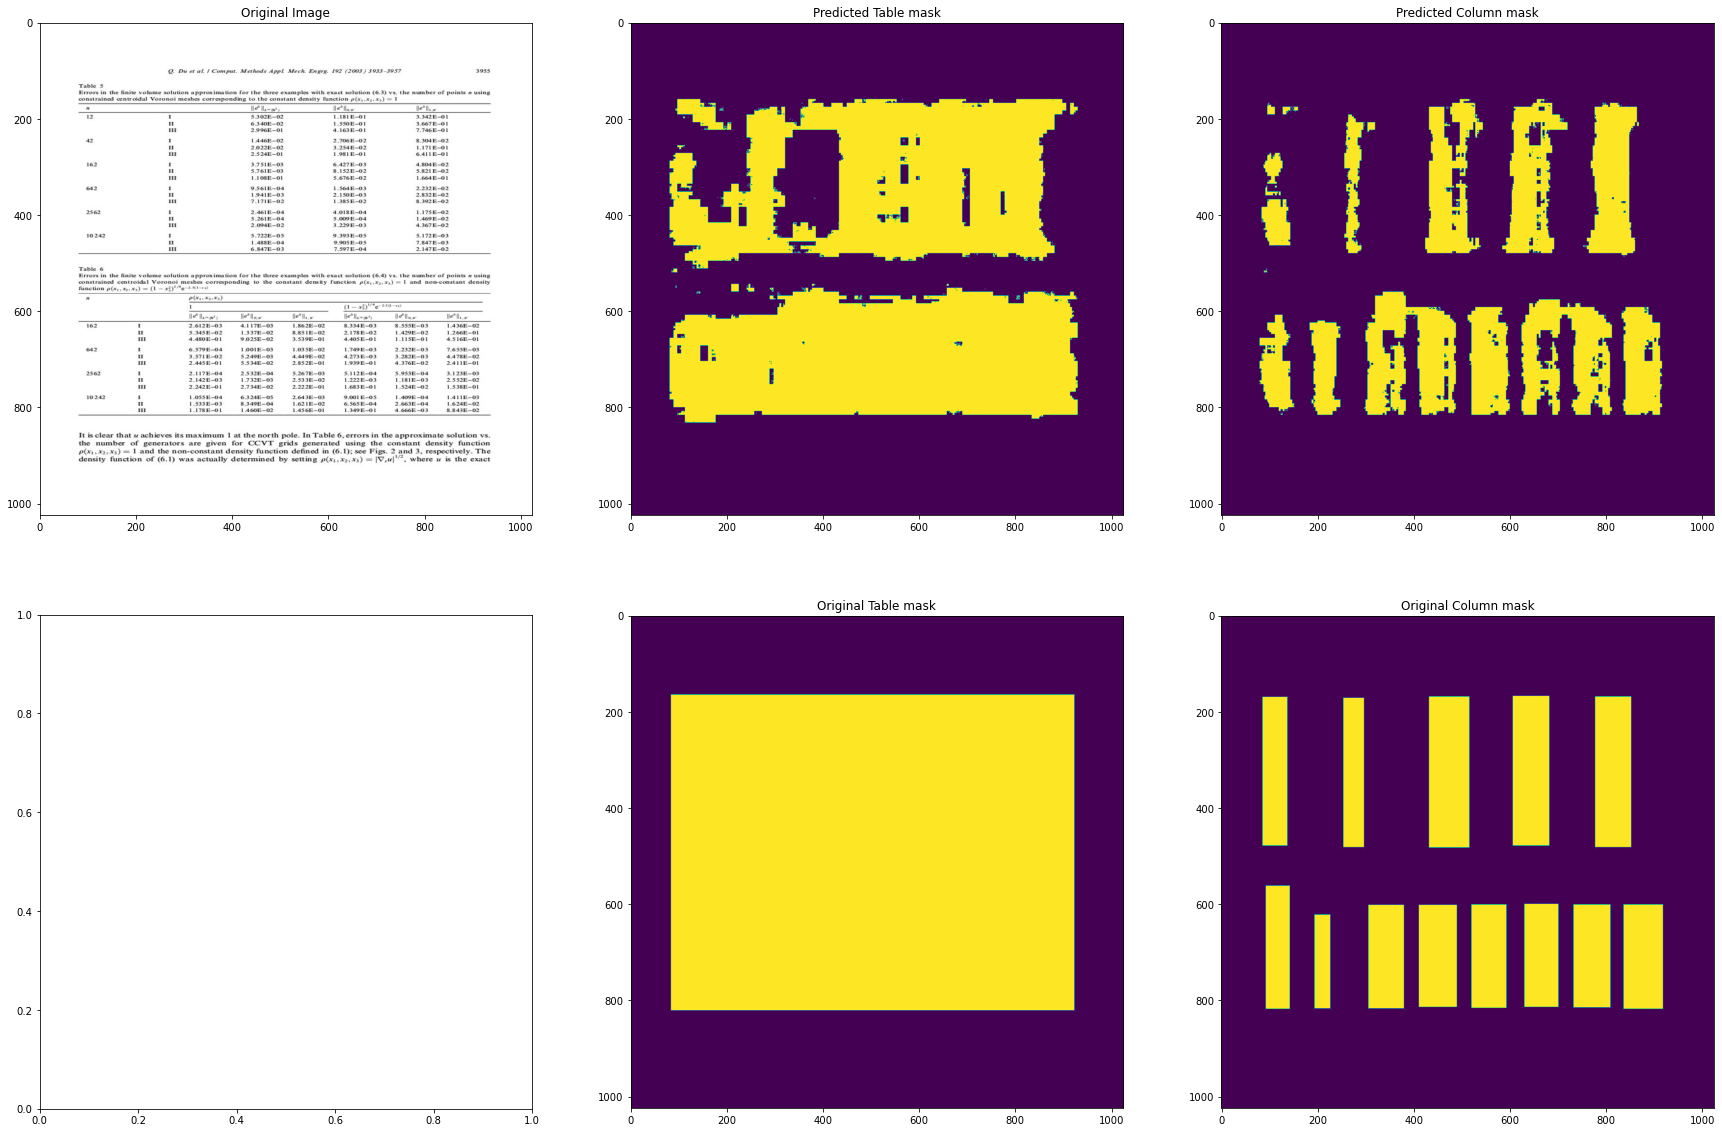

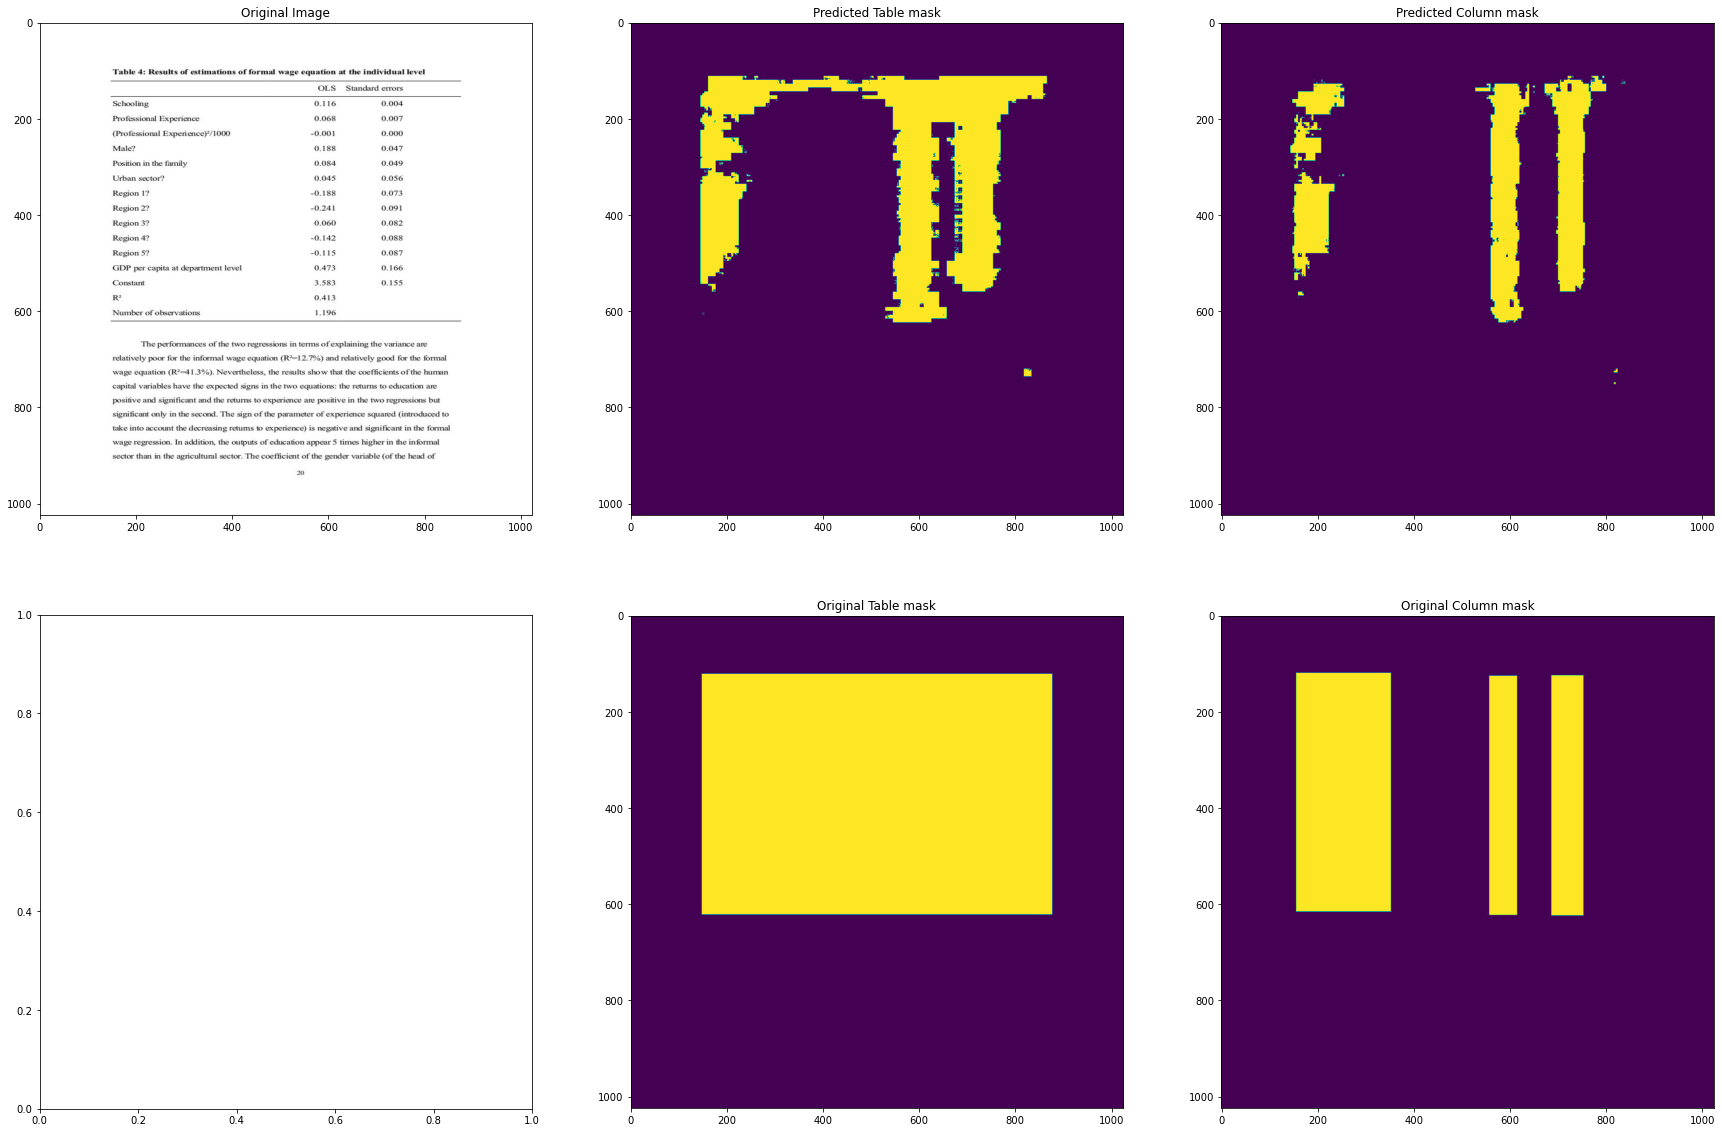

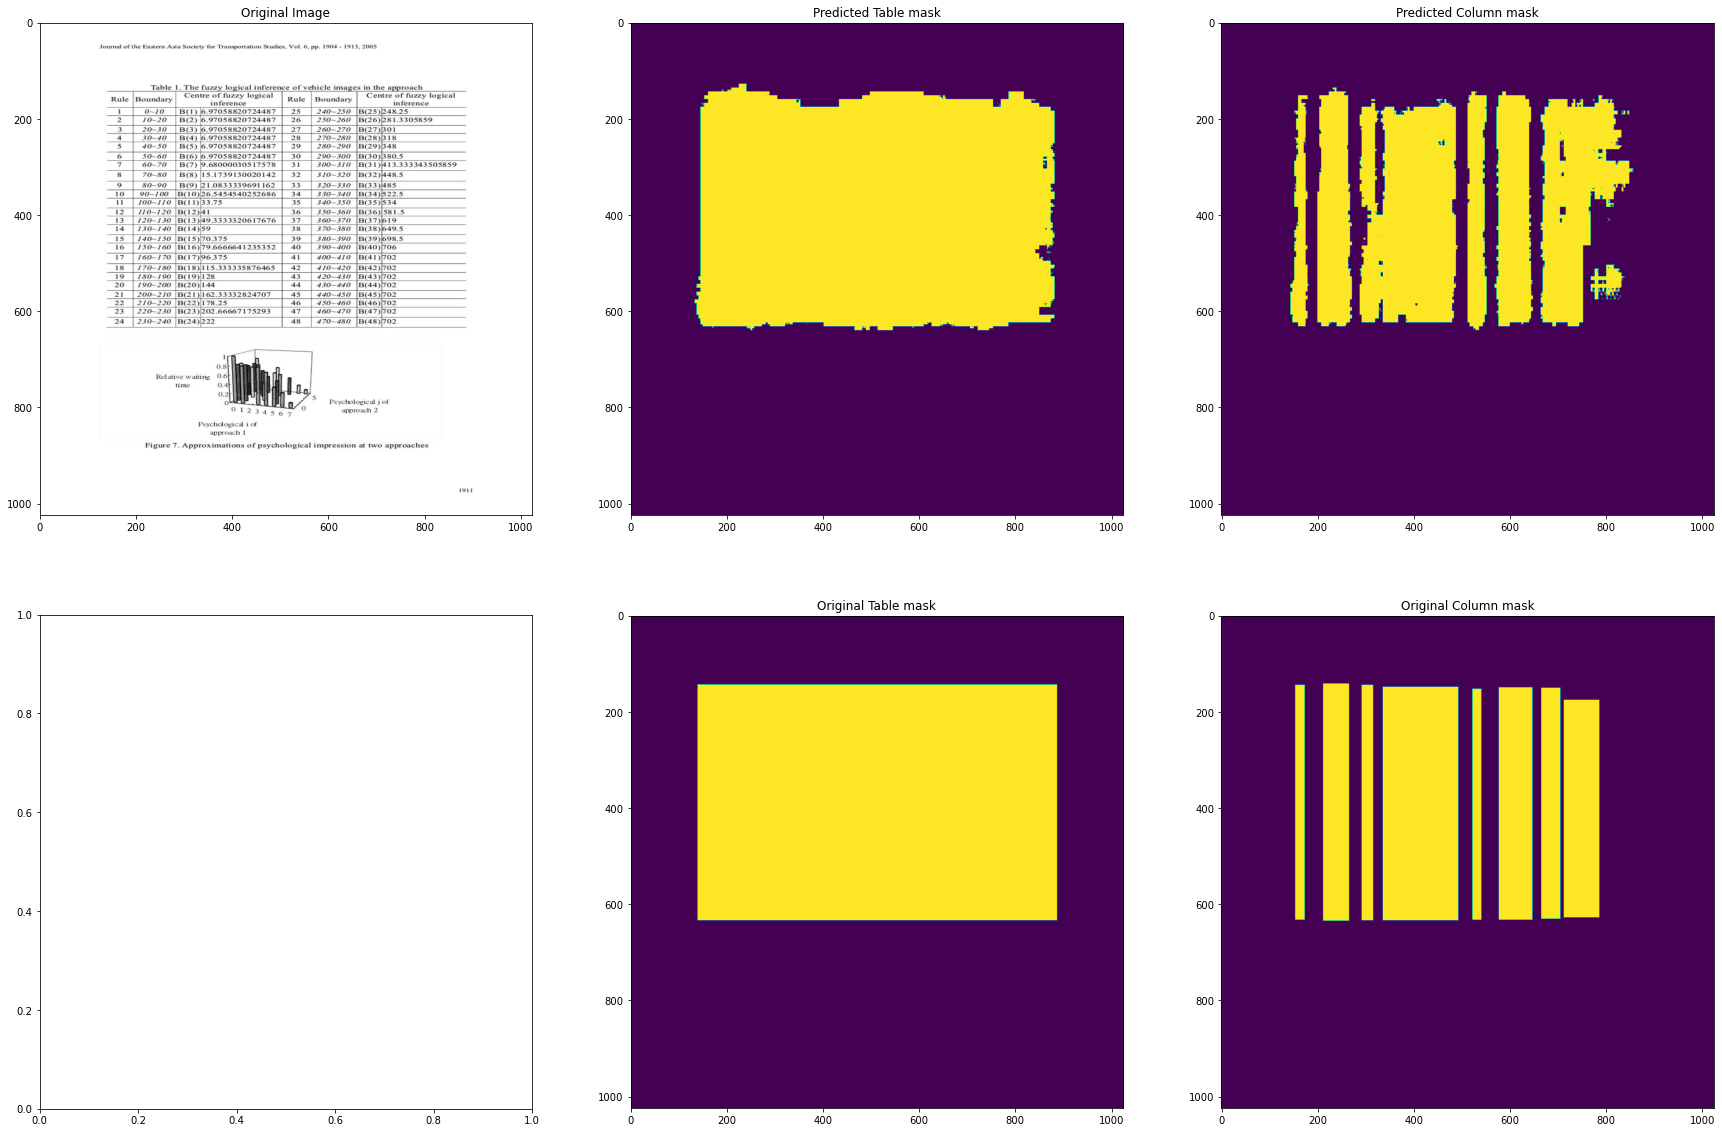

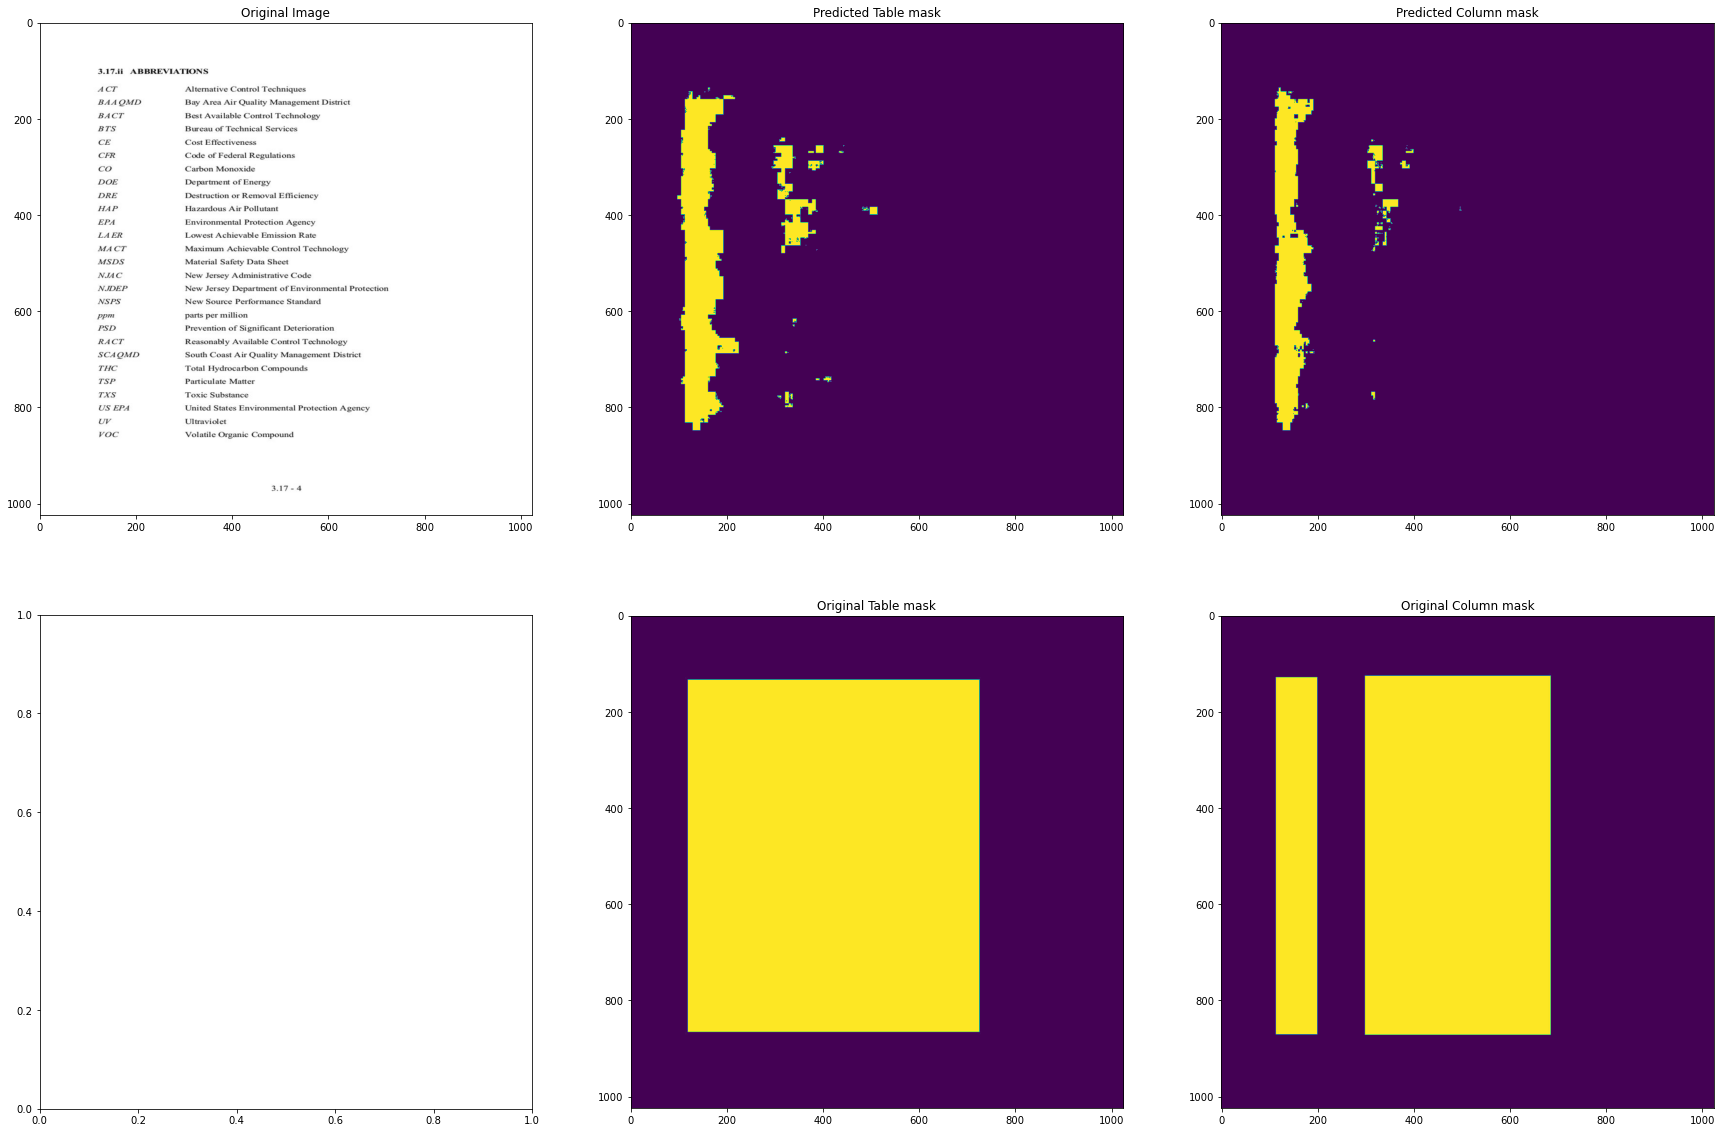

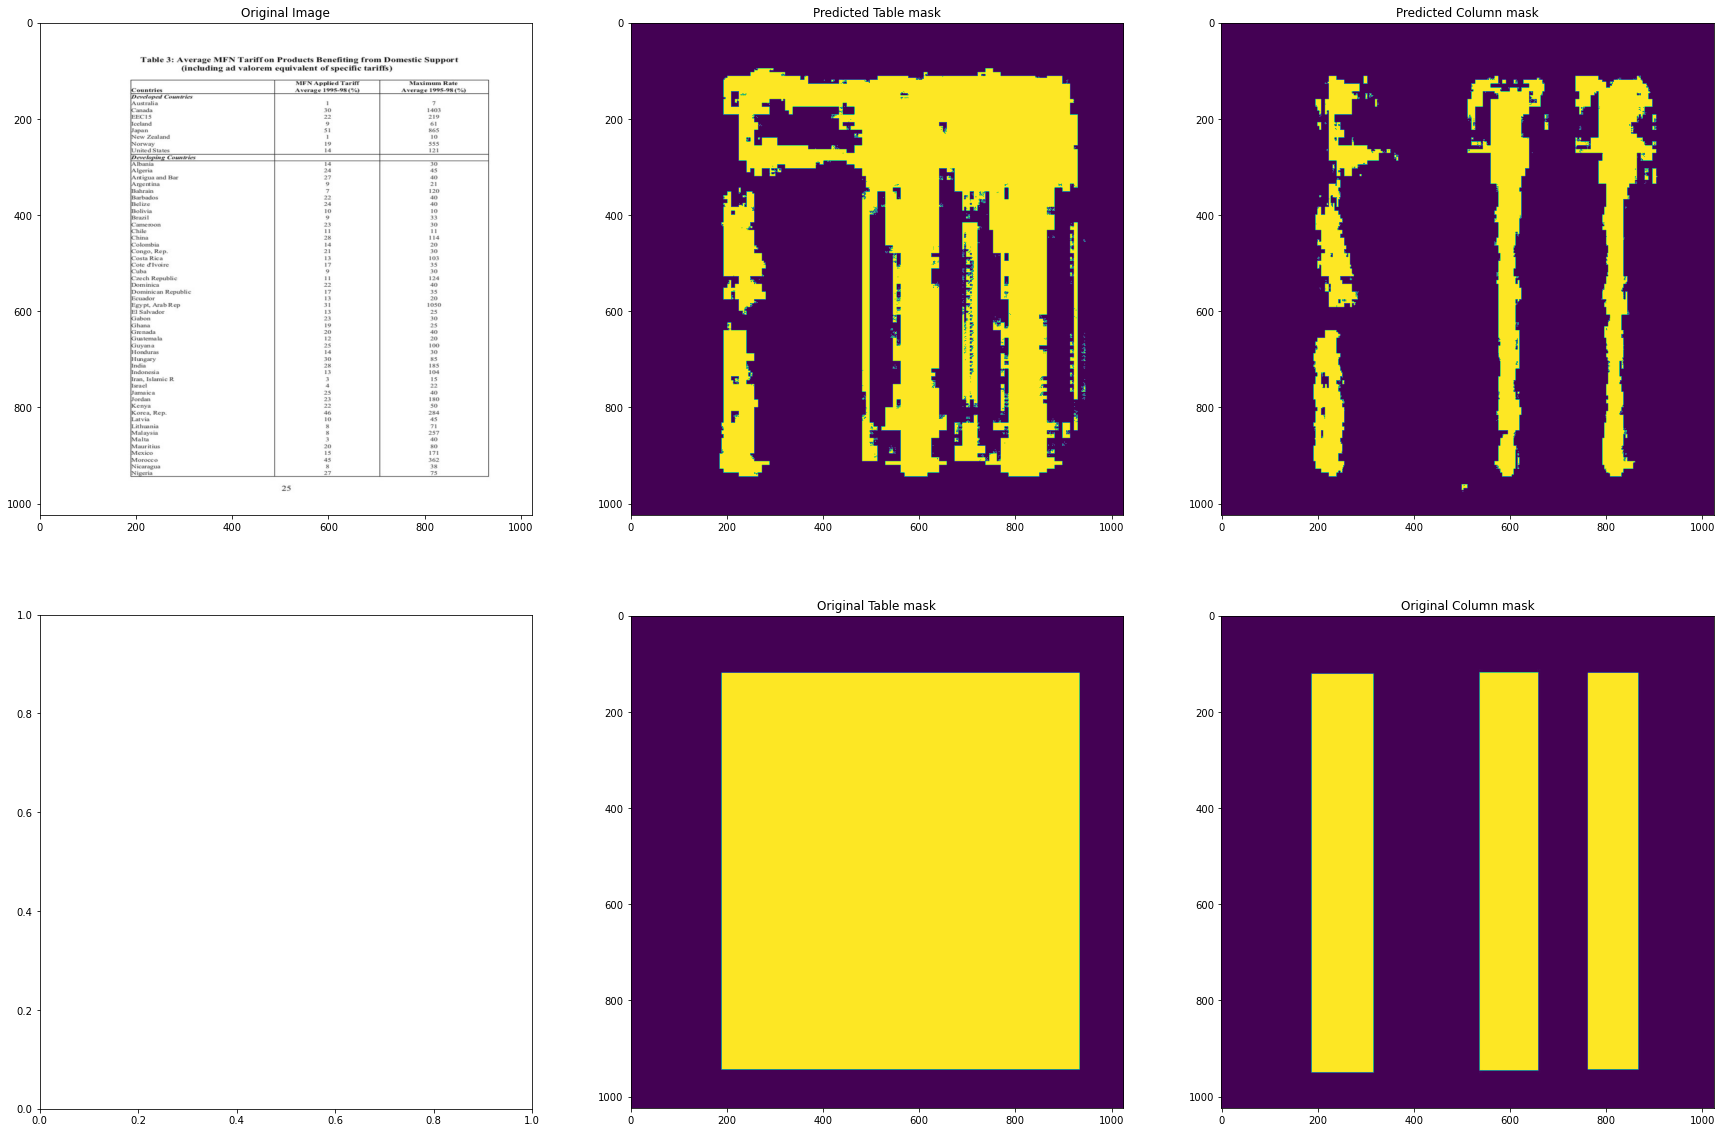

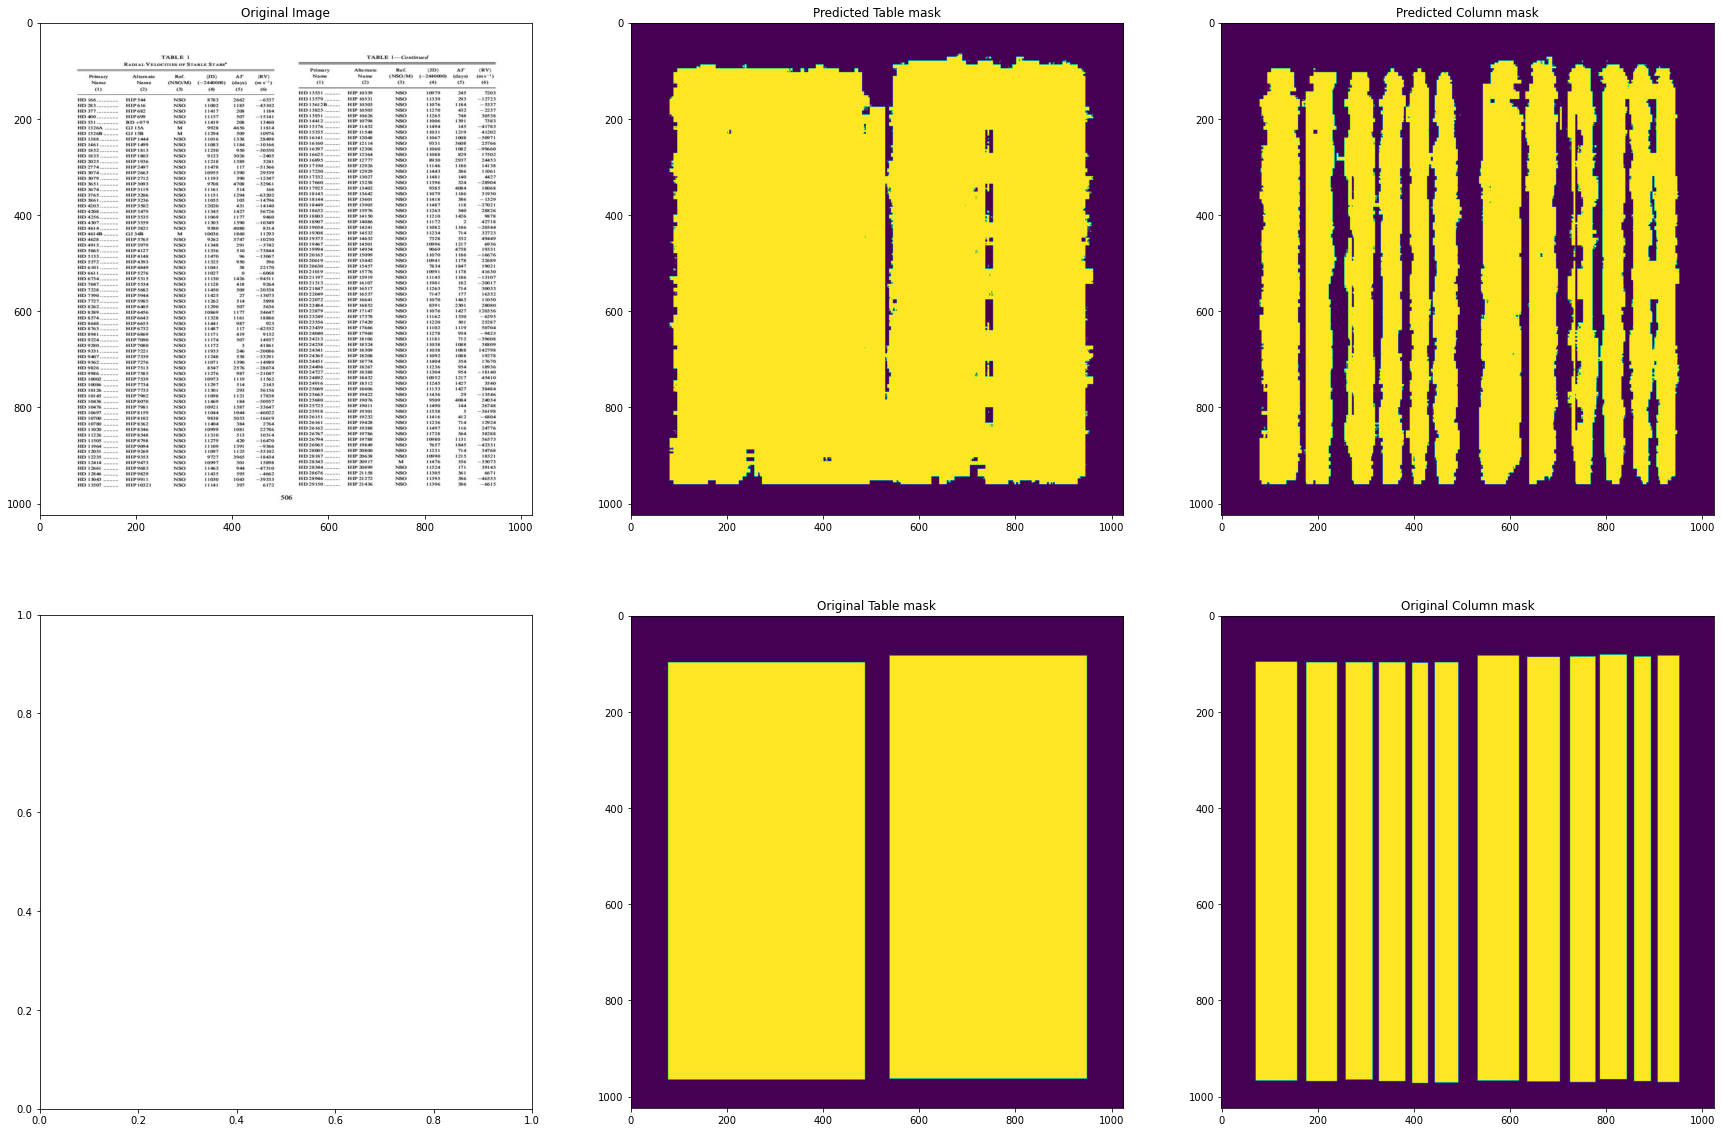

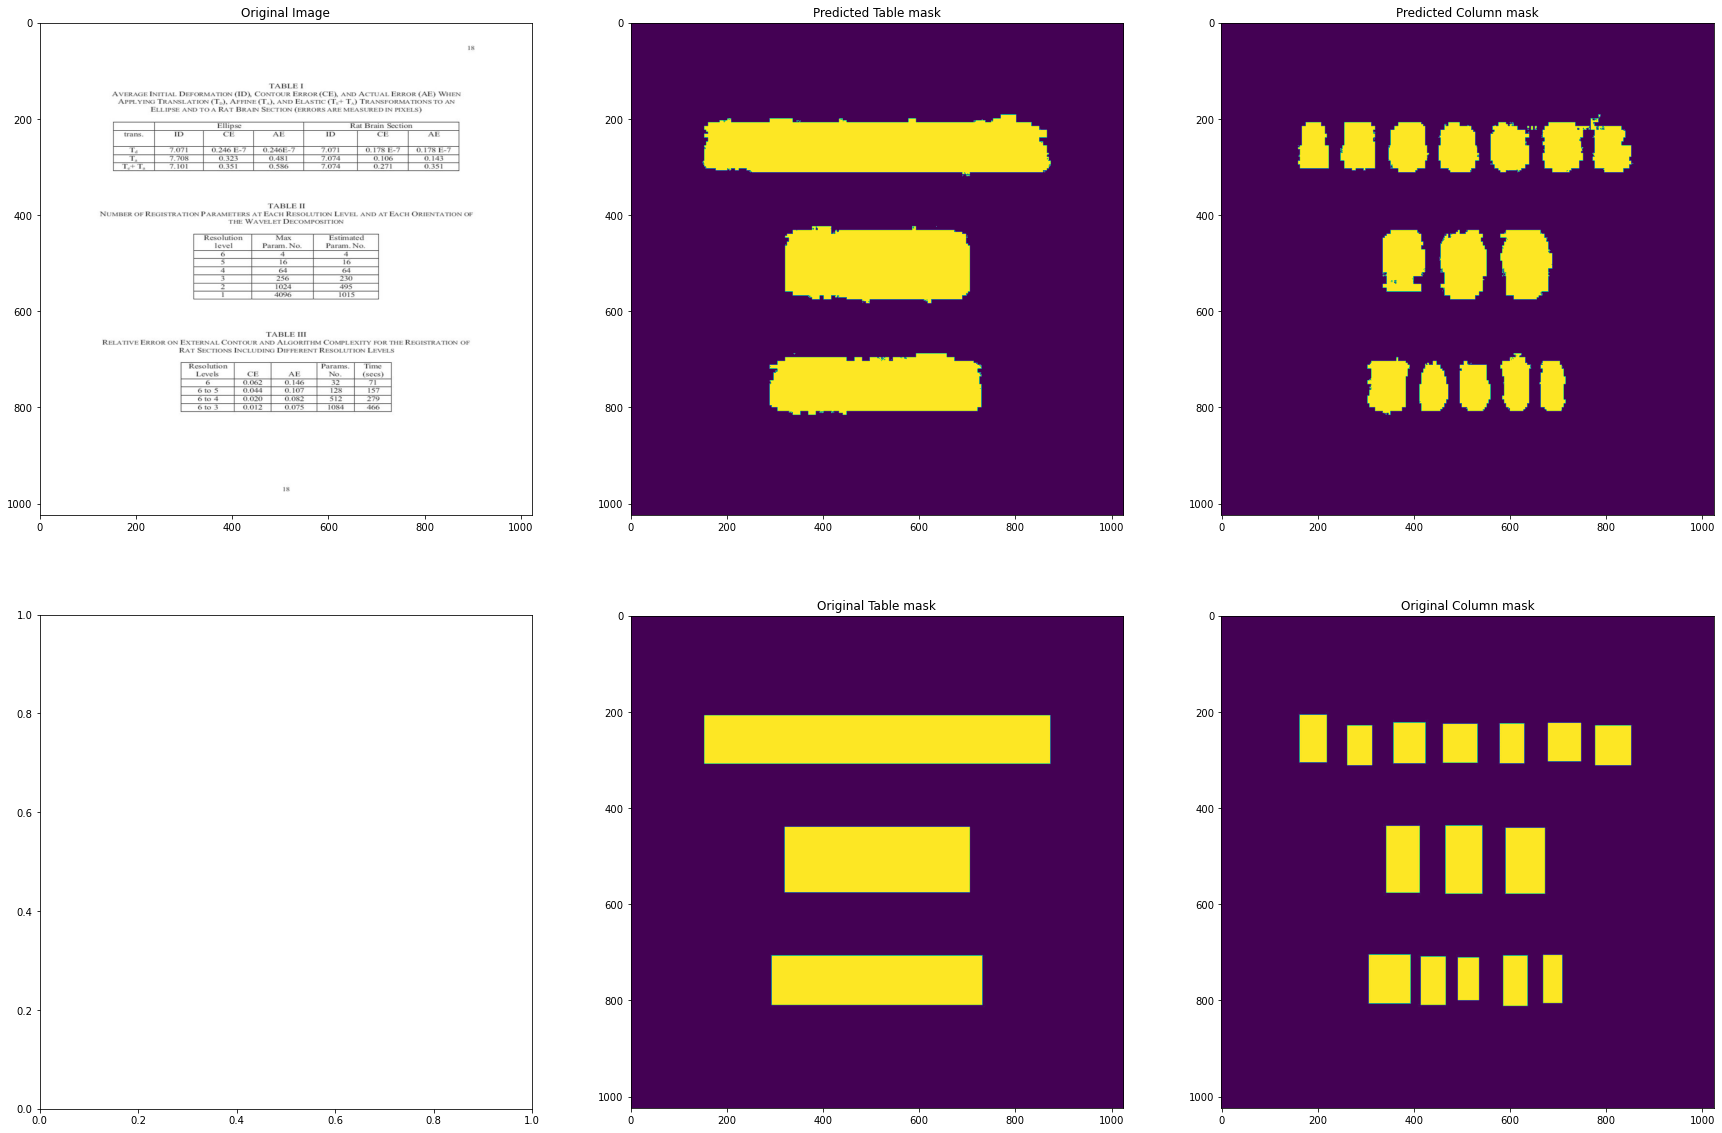

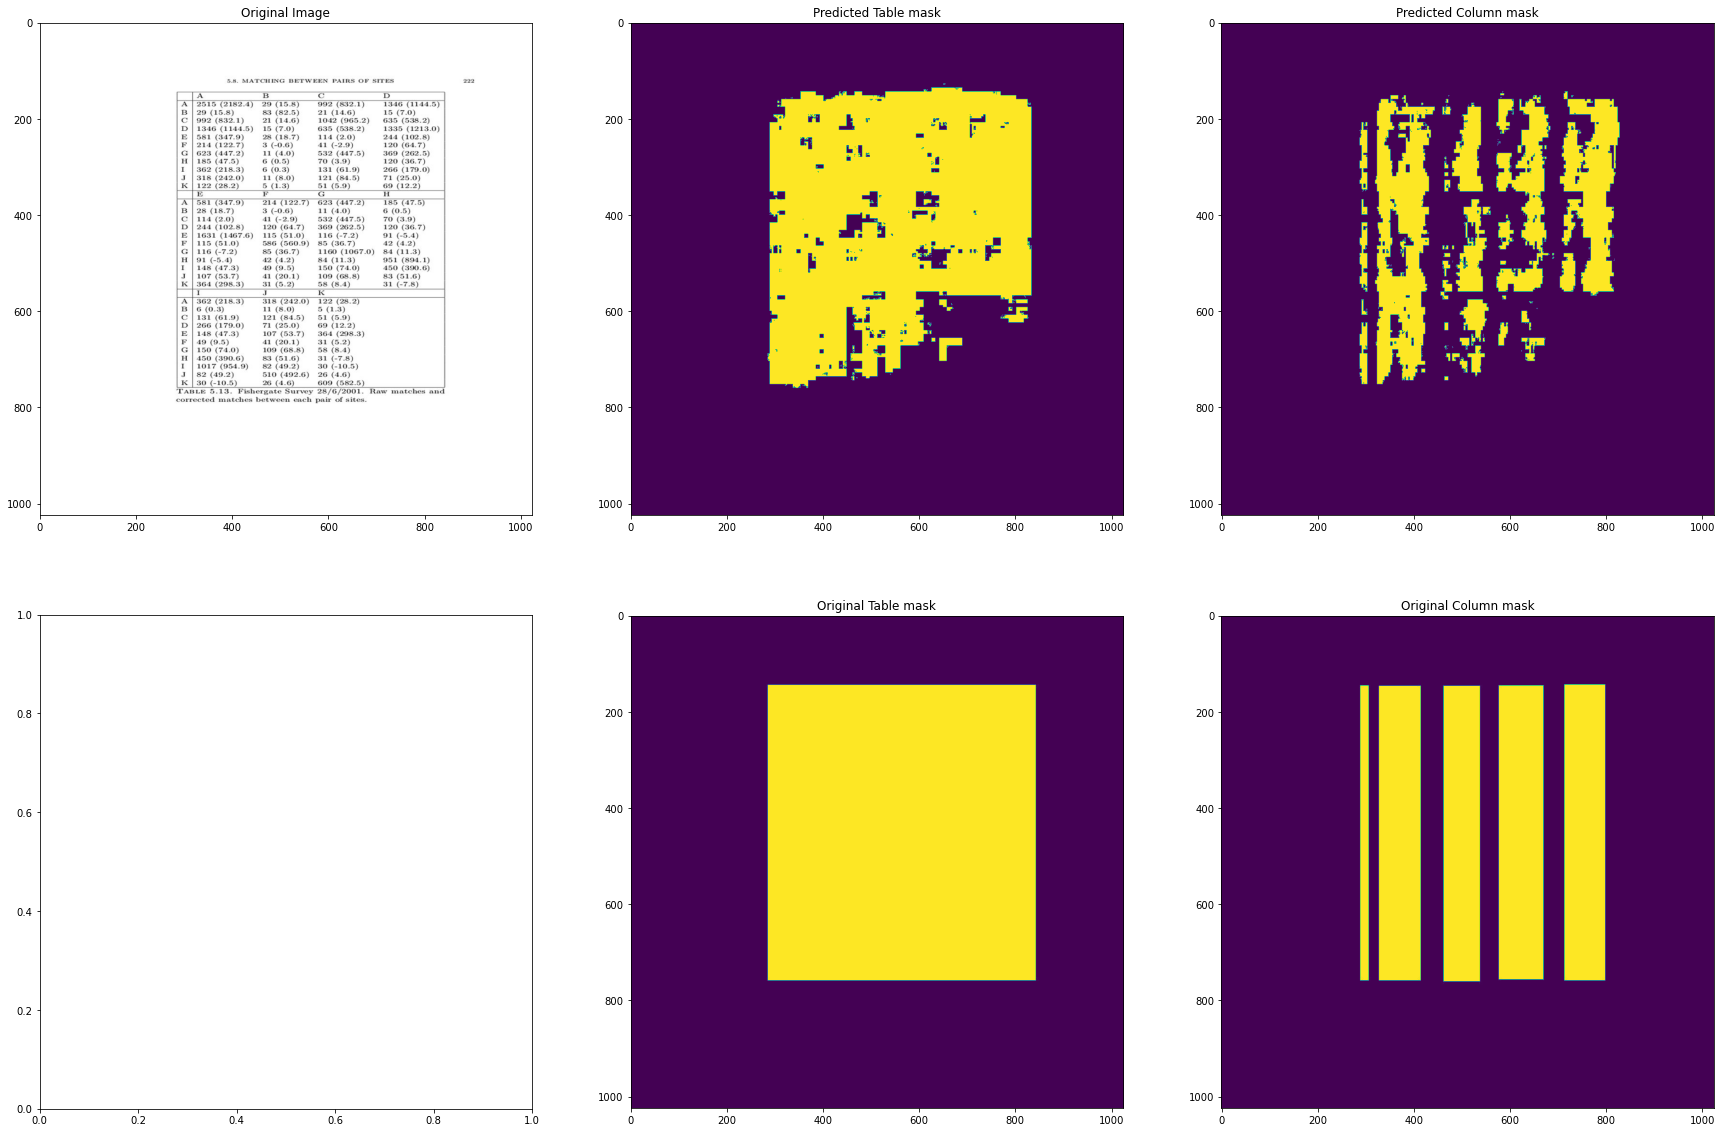

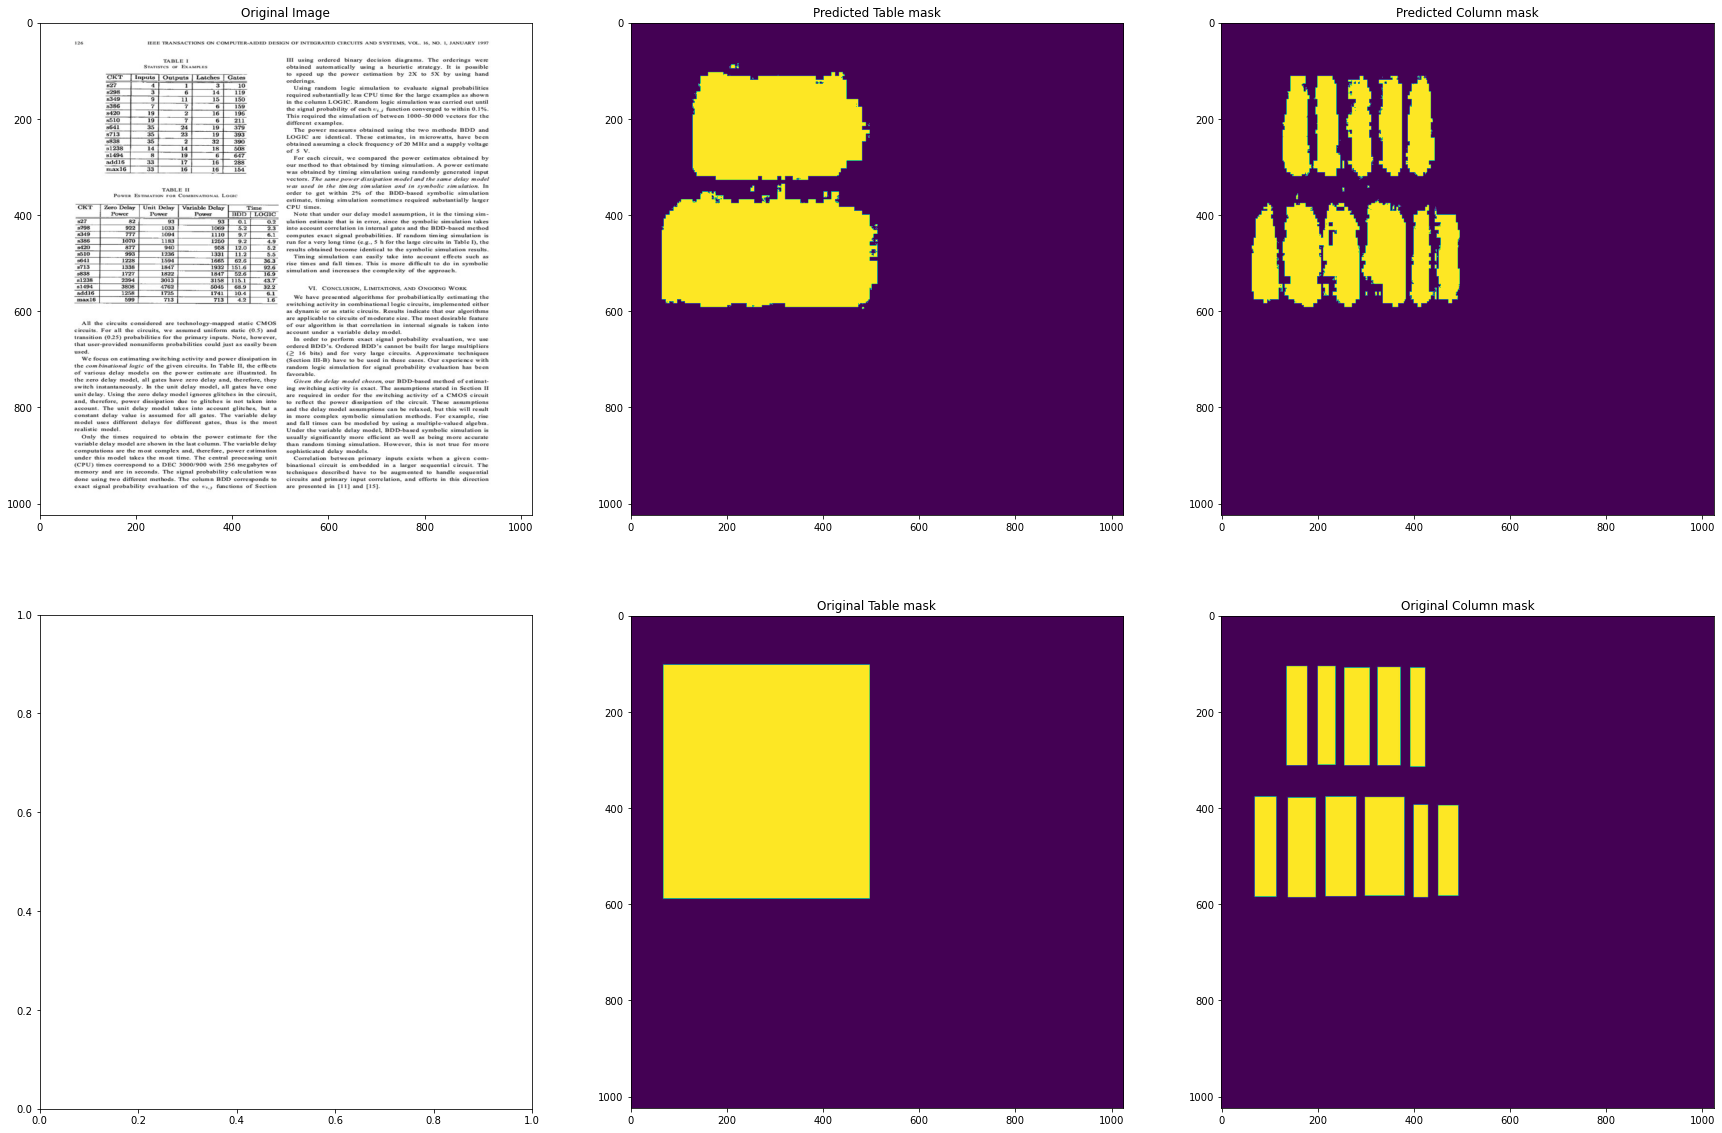

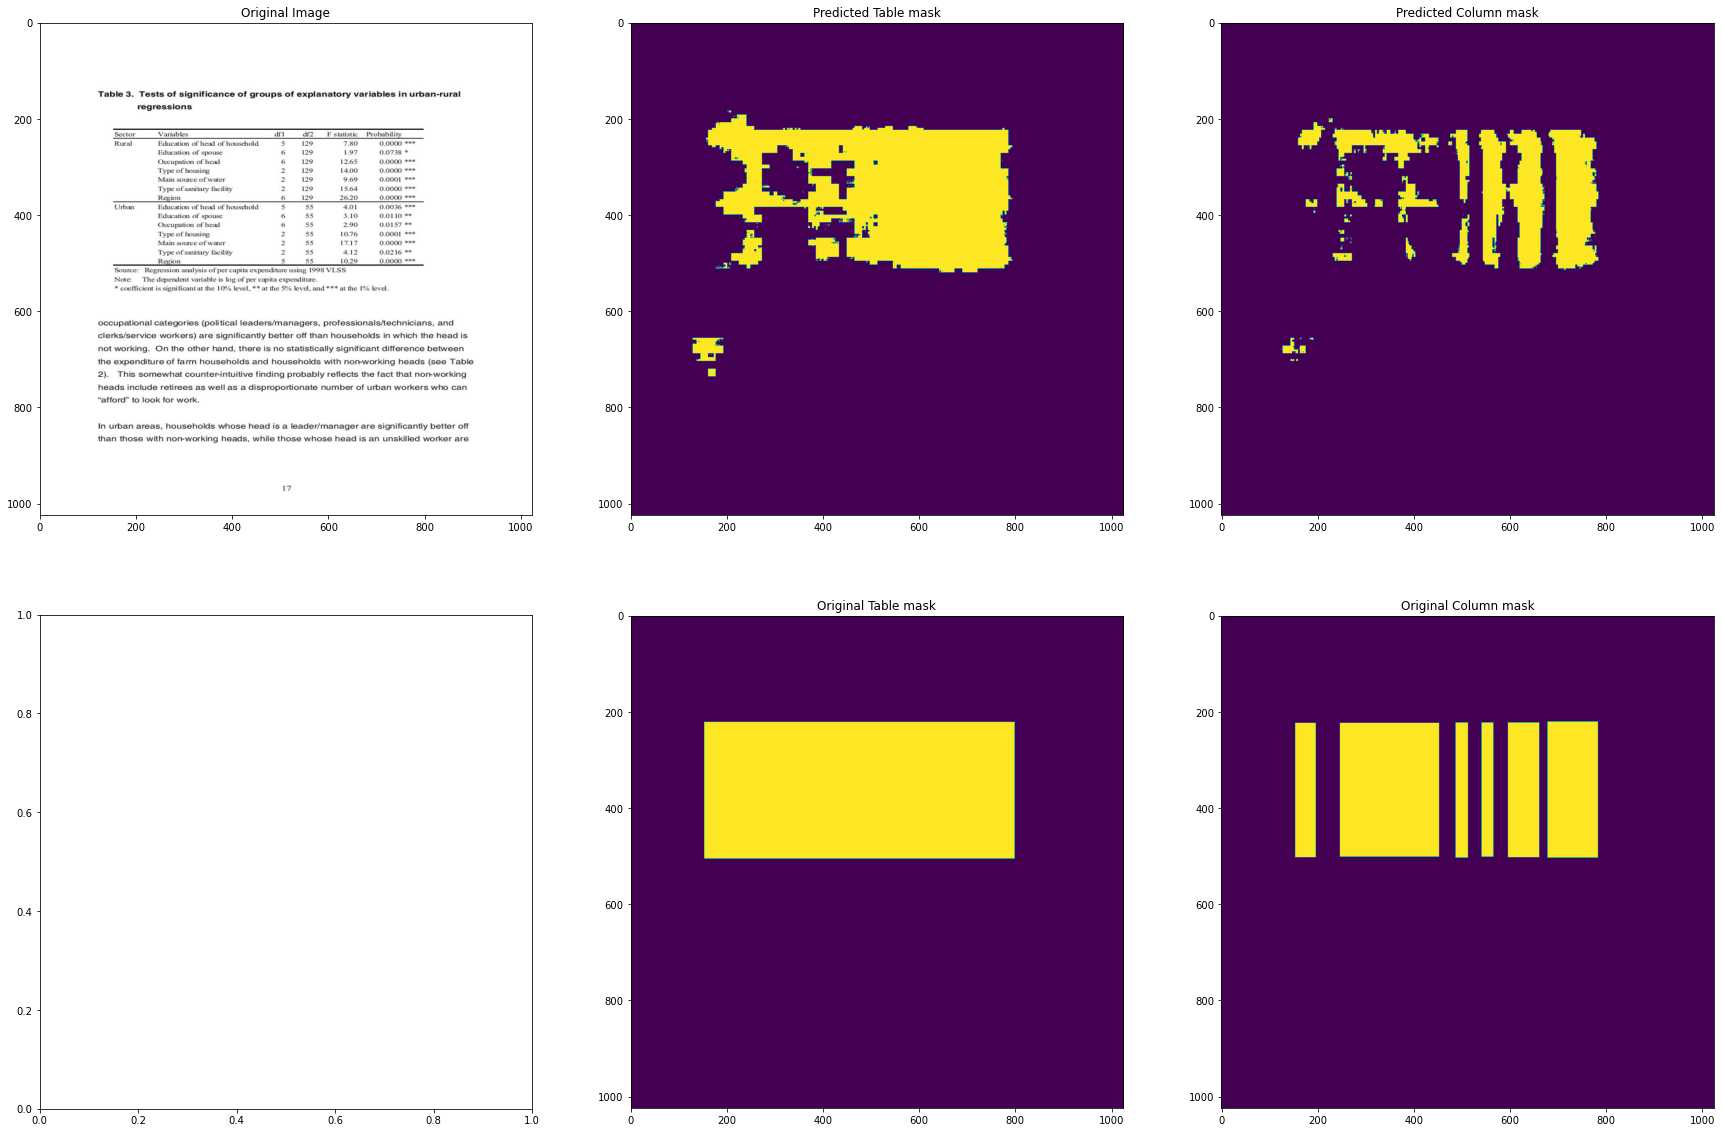

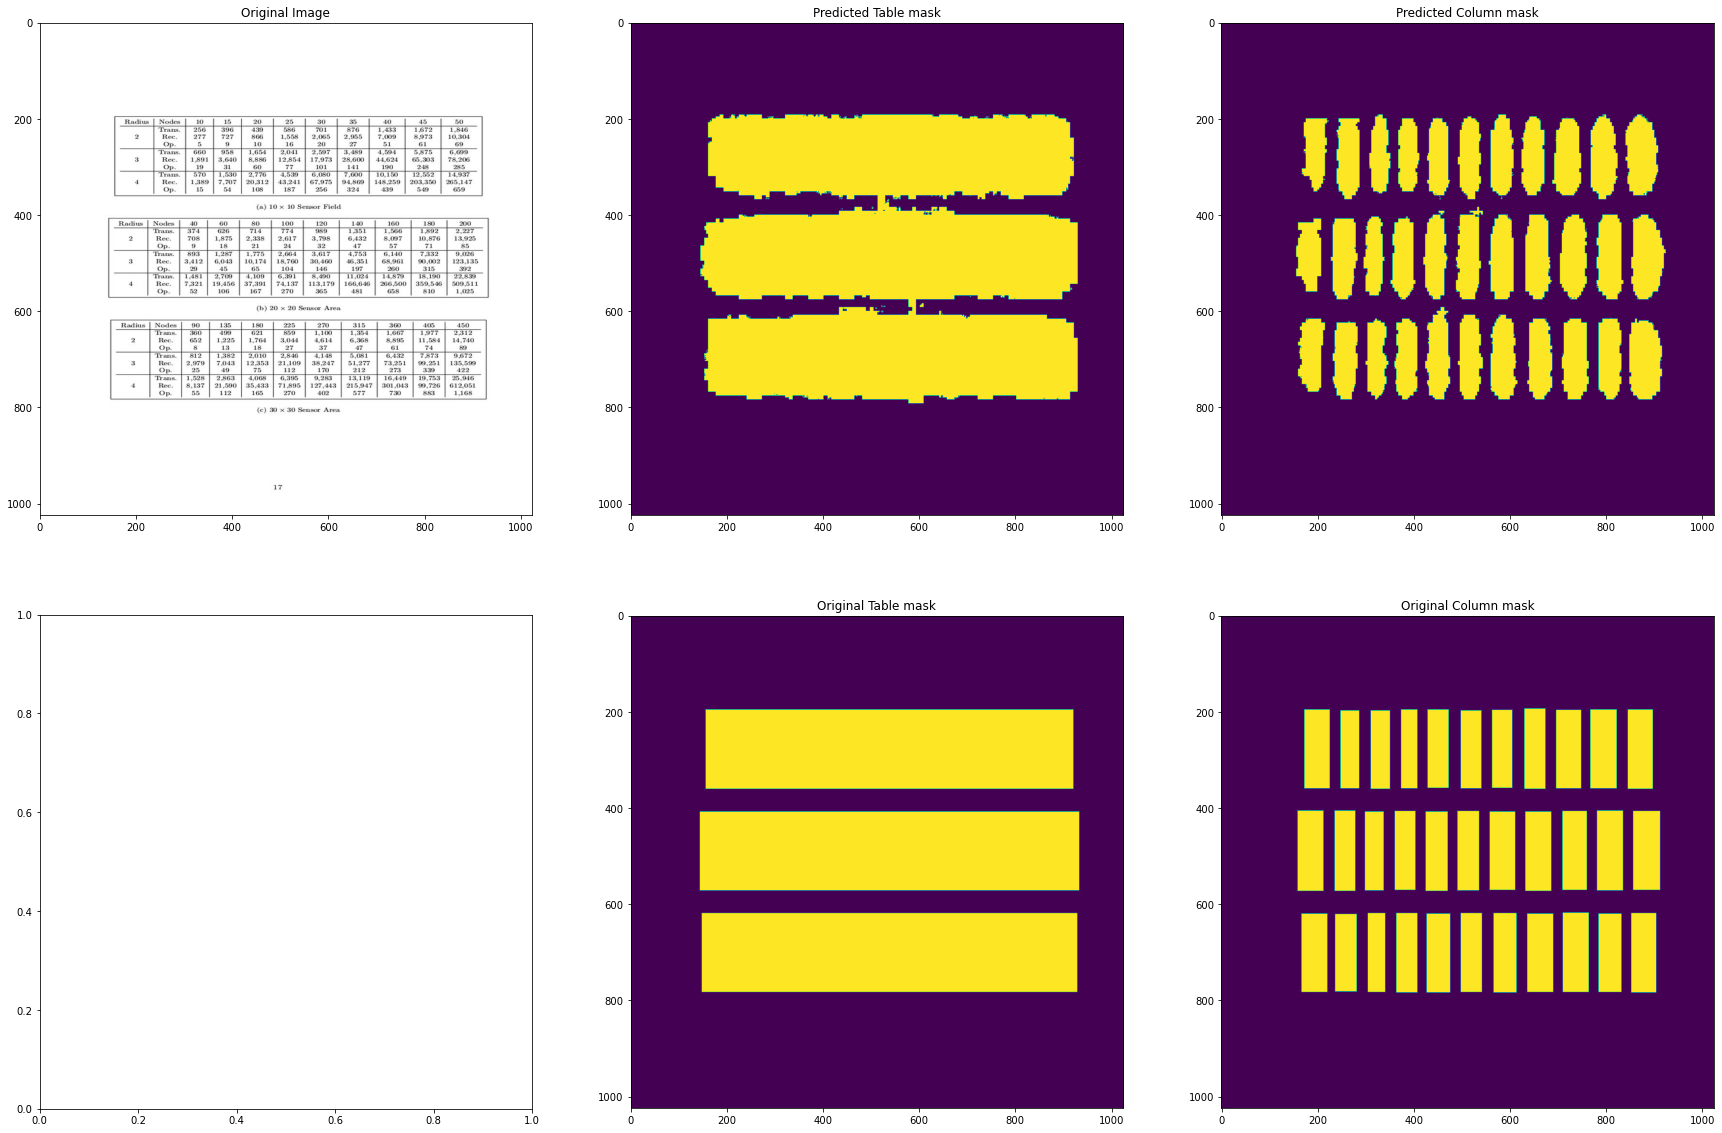

In [198]:
sample_images = ['10.1.1.193.1812_24', '10.1.1.192.1805_60', '10.1.1.178.3008_5', '10.1.1.185.1557_7', '10.1.1.160.686_7',
'10.1.1.160.624_15', '10.1.1.160.538_23', '10.1.1.160.509_17', '10.1.1.120.1603_23', '10.1.1.100.2013_24', 
'10.1.1.100.2026_8', '10.1.1.34.3224_4', '10.1.1.20.2130_26', '10.1.1.7.2189_4', '10.1.1.6.2336_18', 
'10.1.1.1.2134_223', '10.1.1.1.2129_6', '10.1.1.1.2087_26', '10.1.1.1.2044_7', '10.1.1.1.2036_17']

for images in sample_images:
    image_path = 'marmot_preprocessed/'+'image/'+images+'.jpeg'
    visualize_predictions(dense_loaded, image_path)